In [28]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import efinance as ef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import matplotlib.dates as mdates
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

获取数据

In [2]:
def get_data():
    # 假设我们已经得到了沪深300成分股的股票代码列表
    stock_codes = ef.stock.get_members('000300')['股票代码']
    stockdata = ef.stock.get_quote_history(stock_codes, '20160101', '20211231')
    # 合并所有数据到一个DataFrame
    df_all = pd.concat(stockdata, keys=stock_codes, names=['StockCode'])

    # 重命名列名
    df_all.columns = ['Stockname','Stockcode','Date','Open', 'Close', \
    'High', 'Low', 'Volume', 'Amount','Amplitude','Changerate','Changeamount','Turnoverate']
    df_all
    stockdata=df_all.sort_values(by=['Stockcode','Date'])
    stockdata
    stockdata['Close']=stockdata['Close'].replace(0,np.nan)
    stockdata['ret']=stockdata.groupby(['Stockcode'])['Close'].pct_change()
    stockdata['ret']=stockdata['ret'].shift(-1)
    stockdata=stockdata.dropna(subset=['Close','ret'])
    stockdata
    #363045 ret不上移 363045 ret上移过后0104的数据被保留了
    return stockdata

In [3]:
warnings.filterwarnings("ignore")
stockdata=get_data()
stockdata

Processing => 601799: 100%|██████████| 300/300 [00:22<00:00, 13.15it/s]


Stockname Stockcode        Date   Open  Close   High    Low  \
StockCode                                                                   
000001    0        平安银行    000001  2016-01-04   7.56   7.00   7.58   6.92   
          1        平安银行    000001  2016-01-05   6.95   7.06   7.20   6.85   
          2        平安银行    000001  2016-01-06   7.07   7.17   7.19   7.05   
          3        平安银行    000001  2016-01-07   7.07   6.67   7.07   6.65   
          4        平安银行    000001  2016-01-08   6.90   6.82   6.97   6.64   
...                 ...       ...         ...    ...    ...    ...    ...   
688981    352      中芯国际    688981  2021-12-24  52.90  52.56  53.04  52.51   
          353      中芯国际    688981  2021-12-27  52.53  52.70  53.00  52.53   
          354      中芯国际    688981  2021-12-28  52.83  53.17  53.45  52.70   
          355      中芯国际    688981  2021-12-29  53.13  52.73  53.15  52.62   
          356      中芯国际    688981  2021-12-30  52.75  52.89  53.16  52.68   

               Volume       Amount  Amplitude  Changerate  Changeamount  \
StockCode                                                                 
000001    0    563498  660376160.0       8.74       -7.28         -0.55   
          1    663270  755531360.0       5.00        0.86          0.06   
          2    515706  591698528.0       1.98        1.56          0.11   
          3    174761  194869493.0       5.86       -6.97         -0.50   
          4    747528  831334544.0       4.95        2.25          0.15   
...               ...          ...        ...         ...           ...   
688981    352  135848  715087056.0       1.00       -0.44         -0.23   
          353  103070  544100848.0       0.89        0.27          0.14   
          354  125500  664007920.0       1.42        0.89          0.47   
          355  116562  615527728.0       1.00       -0.83         -0.44   
          356  157215  832728112.0       0.91        0.30          0.16   

               Turnoverate       ret  
StockCode                             
000001    0           0.48  0.008571  
          1           0.56  0.015581  
          2           0.44 -0.069735  
          3           0.15  0.022489  
          4           0.63 -0.043988  
...                    ...       ...  
688981    352         0.73  0.002664  
          353         0.55  0.008918  
          354         0.67 -0.008275  
          355         0.62  0.003034  
          356         0.84  0.001891  

[363036 rows x 14 columns]

因子值计算

In [4]:
def calculate_OFI(temp_abpvs):
    factor_0FI = []
    
    for level in [1, 2, 3]:
        temp_bp = temp_abpvs[f'BidPrice{level}'].values
        temp_ap = temp_abpvs[f'AskPrice{level}'].values
        temp_bv = temp_abpvs[f'BidVolume{level}'].values
        temp_av = temp_abpvs[f'AskVolume{level}'].values
        
        alphaTick = np.zeros_like(temp_bp)  # 初始化 alphaTick 数组
        
        for t in range(1, len(temp_abpvs)):
            if temp_bp[t] == temp_bp[t-1]:
                delta_v_B = temp_bv[t] - temp_bv[t - 1]
            elif temp_bp[t] > temp_bp[t-1]:
                delta_v_B = temp_bv[t]
            else:
                delta_v_B = -temp_bv[t - 1]
                
            if temp_ap[t] == temp_ap[t-1]:
                delta_v_A = temp_av[t] - temp_av[t-1]
            elif temp_ap[t] > temp_ap[t-1]:
                delta_v_A = -temp_av[t-1]
            else:
                delta_v_A = temp_av[t]
            
            OFI = (delta_v_B - delta_v_A) / (np.abs(delta_v_B) + np.abs(delta_v_A) + 0.01)
            alphaTick[t] = OFI
        
        # 计算非NaN值的平均值并添加到 factor_0FI 列表中
        factor_0FI.append(np.nanmean(alphaTick))
    
    return -np.array(factor_0FI).sum()
# 动量因子0.0807
def calculate_momentum_factor(data, window_size=5):
    mid_price = data['Close']
    momentum_factor = np.log(mid_price.shift(window_size) / mid_price)
    return momentum_factor

# 波动率因子0.0602
def calculate_volatility_factor(data, window_size=5):
    rtn = np.log(data['Close']).diff()
    volatility_factor = rtn.rolling(window=window_size).std()
    return volatility_factor

# 流动性因子-0.0397
def calculate_liquidity_factor(data):
    liquidity_factor = data['BidVolume1'] + data['AskVolume1']
    return liquidity_factor

# 价差因子0.1721
def calculate_spread_factor(data):
    spread_factor = data['AskPrice1'] - data['BidPrice1']
    return spread_factor

# 成交金额因子0.1017
def calculate_turnover_factor(data):
    turnover_factor = data['Close'] * data['Volume']
    return turnover_factor

'''# 相对强度因子（假设有一个基准指数）
def calculate_relative_strength_factor(data, benchmark):
    relative_strength_factor = np.log(data['中间价']) - np.log(benchmark['中间价'])
    return relative_strength_factor'''

# 价格反转因子0.0789
def calculate_reversal_factor(data, window_size=5):
    reversal_factor = -data['Close'].pct_change(window_size)
    return reversal_factor

# 成交量变化因子-0.059
def calculate_volume_change_factor(data, window_size=5):
    volume_change_factor = data['Volume'].pct_change(window_size)
    return volume_change_factor
#订单簿深度因子-0.0221
def calculate_order_book_depth_factor(data, levels=3):
    bid_depth = sum([data[f'BidVolume{level}'] for level in range(1, levels + 1)])
    ask_depth = sum([data[f'AskVolume{level}'] for level in range(1, levels + 1)])
    order_book_depth_factor = bid_depth - ask_depth
    return order_book_depth_factor
#成交量加权平均-0.1342
def calculate_vwap_factor(data):
    data['vwap'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
    vwap_factor = data['vwap'].pct_change()
    return vwap_factor
#均值回转0.0914
def calculate_mean_reversion_factor(data, window_size=20):
    mean_price = data['Close'].rolling(window=window_size).mean()
    mean_reversion_factor = -(data['Close'] - mean_price) / mean_price
    return mean_reversion_factor
#流动性冲击0.0577
def calculate_liquidity_impact_factor(data):
    liquidity_impact_factor = data['Price'].diff() / (data['BidVolume1'] + data['AskVolume1'])
    return liquidity_impact_factor
#波动率偏度-0.1003
def calculate_volatility_skewness_factor(data, window_size=20):
    rtn = np.log(data['Close']).diff()
    skewness = rtn.rolling(window=window_size).skew()
    return skewness

In [81]:
#因子列矩阵宽表
def calculate_factor(stockdata):
    window_size = 5
    stockdata=stockdata.sort_values(by=['Stockcode','Date'])
    stockdata['momentum3d']=(
        stockdata.groupby('Stockcode')['Close'].shift(1)/stockdata.groupby('Stockcode')['Close'].shift(4)-1
    )
    stockdata['momentum5d']=(
        stockdata.groupby('Stockcode')['Close'].shift(1)/stockdata.groupby('Stockcode')['Close'].shift(6)-1
    )
    stockdata['Volume_Change_Rate'] = stockdata.groupby('Stockcode')['Volume'].pct_change()
    stockdata['my_factor'] = stockdata['Amplitude'] * stockdata['Volume_Change_Rate']
    stockdata['momentum_factor'] = calculate_momentum_factor(stockdata)
    stockdata['volatility_factor'] = calculate_volatility_factor(stockdata)
    stockdata['turnover_factor'] = calculate_turnover_factor(stockdata)
    stockdata['reversal_factor'] = calculate_reversal_factor(stockdata)
    stockdata['volume_change_factor'] = calculate_volume_change_factor(stockdata)
    stockdata['vwap_factor'] = calculate_vwap_factor(stockdata)
    stockdata['mean_reversion_factor'] = calculate_mean_reversion_factor(stockdata)
    stockdata['volatility_skewness_factor'] = calculate_volatility_skewness_factor(stockdata)   
    return stockdata.loc[:,['Stockcode','Date','momentum3d', 'momentum5d', 'my_factor', 'momentum_factor',
       'volatility_factor', 'turnover_factor', 'reversal_factor',
       'volume_change_factor', 'vwap_factor', 'mean_reversion_factor',
       'volatility_skewness_factor']].fillna(0)
result_df=calculate_factor(stockdata)
result_df.set_index(['Date','Stockcode'], inplace=True)
result_df

,,momentum3d,momentum5d,my_factor,momentum_factor,volatility_factor,turnover_factor,reversal_factor,volume_change_factor,vwap_factor,mean_reversion_factor,volatility_skewness_factor
Date,Stockcode,,,,,,,,,,,
2016-01-04,000001,0.000000,0.000000,0.000000,0.000000,0.000000,3944486.00,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,000001,0.000000,0.000000,0.885292,0.000000,0.000000,4682686.20,0.000000,0.000000,0.004634,0.000000,0.000000
2016-01-06,000001,0.000000,0.000000,-0.440509,0.000000,0.000000,3697612.02,0.000000,0.000000,0.005789,0.000000,0.000000
2016-01-07,000001,0.000000,0.000000,-3.874180,0.000000,0.000000,1165655.87,0.000000,0.000000,-0.005195,0.000000,0.000000
2016-01-08,000001,-0.047143,0.000000,16.223280,0.000000,0.000000,5098140.96,0.000000,0.000000,-0.008627,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,688981,-0.001513,-0.012163,0.066420,0.017539,0.005687,7140170.88,0.017386,-0.184214,0.000003,0.029291,0.498088
2021-12-27,688981,-0.009797,-0.017386,-0.214743,0.003221,0.003872,5431789.00,0.003215,-0.504452,0.000002,0.025310,0.455250
2021-12-28,688981,-0.006035,-0.003215,0.309019,-0.001694,0.005581,6672835.00,-0.001696,-0.148396,0.000002,0.015626,0.342333


1.每个时间t有一个股票代码——因子名矩阵，每列是一个股票截面，每列对应一个ri,一共n列得到t对应的rp

2.sqrt(n/(1+(n-1)*rou))

3.rou=0:sharpe->inf
rou!=0：sharpe->1/sqrt(abs(rou))
相关性越小 sharpe越大

In [82]:
def standardize(column):
    """标准化函数：(x - mean) / std"""
    if pd.api.types.is_numeric_dtype(column):  # 确保只对数值类型的数据进行操作
        mean = column.mean()
        std = column.std()
        if std == 0:
            print(f"Skipping column {column.name} because its standard deviation is 0.")
            return column  # 如果标准差为0，则返回原列数据
        return (column - mean) / std
    else:
        return column  # 非数值类型的列直接返回

# 使用 apply 方法对 DataFrame 的每一列应用 standardize 函数
result_df = result_df.apply(standardize)
result_df

,,momentum3d,momentum5d,my_factor,momentum_factor,volatility_factor,turnover_factor,reversal_factor,volume_change_factor,vwap_factor,mean_reversion_factor,volatility_skewness_factor
Date,Stockcode,,,,,,,,,,,
2016-01-04,000001,-0.007105,-0.010674,-0.004831,0.000558,-0.506160,-0.170674,0.010191,-0.029919,-0.021213,NaN,-0.092593
2016-01-05,000001,-0.007105,-0.010674,-0.001495,0.000558,-0.506160,-0.095317,0.010191,-0.029919,56.165864,NaN,-0.092593
2016-01-06,000001,-0.007105,-0.010674,-0.006492,0.000558,-0.506160,-0.195876,0.010191,-0.029919,70.169189,NaN,-0.092593
2016-01-07,000001,-0.007105,-0.010674,-0.019432,0.000558,-0.506160,-0.454343,0.010191,-0.029919,-63.012540,NaN,-0.092593
2016-01-08,000001,-0.113045,-0.010674,0.056307,0.000558,-0.506160,-0.052907,0.010191,-0.029919,-104.622921,NaN,-0.092593
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,688981,-0.010506,-0.034268,-0.004581,0.115176,-0.408213,0.155547,0.043122,-0.045980,0.010586,NaN,0.434982
2021-12-27,688981,-0.029120,-0.044401,-0.005641,0.021605,-0.439474,-0.018848,0.016281,-0.073899,0.002999,NaN,0.389608
2021-12-28,688981,-0.020668,-0.016911,-0.003667,-0.010513,-0.410038,0.107841,0.006979,-0.042857,0.008619,NaN,0.270007


In [7]:
#股票代码变col_index
df_unstacked = result_df.unstack(level=1)
df_swapped = df_unstacked.swaplevel(i=0, j=1, axis=1).sort_index(axis=1).fillna(0)
df_swapped

Stockcode                 000001                                        \
           mean_reversion_factor momentum3d momentum5d momentum_factor   
Date                                                                     
2016-01-04                   0.0  -0.007105  -0.010674        0.000558   
2016-01-05                   0.0  -0.007105  -0.010674        0.000558   
2016-01-06                   0.0  -0.007105  -0.010674        0.000558   
2016-01-07                   0.0  -0.007105  -0.010674        0.000558   
2016-01-08                   0.0  -0.113045  -0.010674        0.000558   
...                          ...        ...        ...             ...   
2021-12-24                   0.0  -0.035125  -0.058453        0.107019   
2021-12-27                   0.0  -0.046163  -0.042020        0.123939   
2021-12-28                   0.0  -0.031117  -0.046955        0.173188   
2021-12-29                   0.0  -0.028386  -0.061247        0.268866   
2021-12-30                   0.0  -0.086602  -0.088707        0.210162   

Stockcode                                                               \
           my_factor reversal_factor turnover_factor volatility_factor   
Date                                                                     
2016-01-04 -0.004831        0.010191       -0.170674         -0.506160   
2016-01-05 -0.001495        0.010191       -0.095317         -0.506160   
2016-01-06 -0.006492        0.010191       -0.195876         -0.506160   
2016-01-07 -0.019432        0.010191       -0.454343         -0.506160   
2016-01-08  0.056307        0.010191       -0.052907         -0.506160   
...              ...             ...             ...               ...   
2021-12-24 -0.006620        0.040797        0.215657         -0.400171   
2021-12-27 -0.002582        0.045616        0.601404         -0.398571   
2021-12-28 -0.001733        0.059571        1.231163         -0.429633   
2021-12-29 -0.001472        0.086382        1.717111         -0.321145   
2021-12-30 -0.007437        0.069979        0.674190         -0.296197   

Stockcode                                                   ...     688981  \
           volatility_skewness_factor volume_change_factor  ... momentum3d   
Date                                                        ...              
2016-01-04                  -0.092593            -0.029919  ...   0.000000   
2016-01-05                  -0.092593            -0.029919  ...   0.000000   
2016-01-06                  -0.092593            -0.029919  ...   0.000000   
2016-01-07                  -0.092593            -0.029919  ...   0.000000   
2016-01-08                  -0.092593            -0.029919  ...   0.000000   
...                               ...                  ...  ...        ...   
2021-12-24                  -0.802874            -0.046436  ...  -0.010506   
2021-12-27                  -0.785357            -0.031708  ...  -0.029120   
2021-12-28                  -0.800767            -0.007200  ...  -0.020668   
2021-12-29                  -0.588338             0.014027  ...   0.009071   
2021-12-30                  -0.660109            -0.051552  ...   0.000163   

Stockcode                                                        \
           momentum5d momentum_factor my_factor reversal_factor   
Date                                                              
2016-01-04   0.000000        0.000000  0.000000        0.000000   
2016-01-05   0.000000        0.000000  0.000000        0.000000   
2016-01-06   0.000000        0.000000  0.000000        0.000000   
2016-01-07   0.000000        0.000000  0.000000        0.000000   
2016-01-08   0.000000        0.000000  0.000000        0.000000   
...               ...             ...       ...             ...   
2021-12-24  -0.034268        0.115176 -0.004581        0.043122   
2021-12-27  -0.044401        0.021605 -0.005641        0.016281   
2021-12-28  -0.016911       -0.010513 -0.003667        0.006979   
2021-12-29  -0.007385        

In [8]:
#动量因子之间相关性低是因为时间太长了 缩短区间则相关性很高
corr_matrix = result_df.corr()
corr_matrix

,momentum3d,momentum5d,my_factor,momentum_factor,volatility_factor,turnover_factor,reversal_factor,volume_change_factor,vwap_factor,mean_reversion_factor,volatility_skewness_factor
momentum3d,1.000000,-0.045044,0.004189,-0.088669,0.041346,0.015127,-0.134320,0.008557,0.001401,NaN,0.012564
momentum5d,-0.045044,1.000000,0.001029,-0.088040,0.002016,0.019464,-0.091338,0.013314,0.001841,NaN,0.017380
my_factor,0.004189,0.001029,1.000000,-0.000333,0.005525,0.004320,-0.003518,0.009852,-0.000125,NaN,-0.001115
momentum_factor,-0.088669,-0.088040,-0.000333,1.000000,0.492540,-0.068657,0.301384,-0.014577,-0.010230,NaN,-0.225932
volatility_factor,0.041346,0.002016,0.005525,0.492540,1.000000,0.044177,-0.039200,0.032330,-0.004350,NaN,-0.164204
turnover_factor,0.015127,0.019464,0.004320,-0.068657,0.044177,1.000000,-0.023419,0.029522,0.117822,NaN,0.058815
reversal_factor,-0.134320,-0.091338,-0.003518,0.301384,-0.039200,-0.023419,1.000000,-0.009516,-0.002717,NaN,-0.049574
volume_change_factor,0.008557,0.013314,0.009852,-0.014577,0.032330,0.029522,-0.009516,1.000000,-0.003562,NaN,-0.035961
vwap_factor,0.001401,0.001841,-0.000125,-0.010230,-0.004350,0.117822,-0.002717,-0.003562,1.000000,NaN,0.013498
mean_reversion_factor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


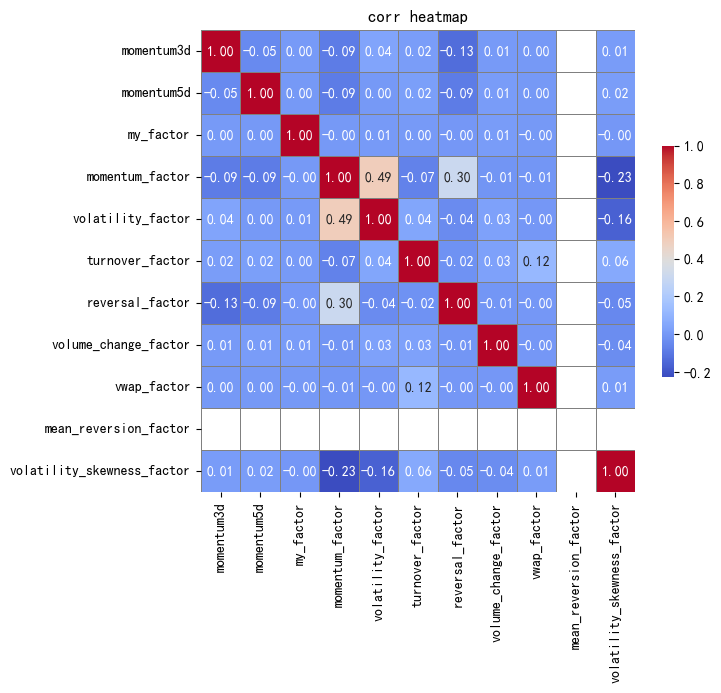

In [9]:
#正交前相关性矩阵
plt.figure(figsize=(7,6))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt=".2f",linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .5})
plt.title("corr heatmap")
plt.show()

In [10]:
#因子名列多个因子factor_data长表 ret_long长表
def calculate_factor(stockdata):
    window_size = 5
    stockdata=stockdata.sort_values(by=['Stockcode','Date'])
    stockdata['momentum3d']=(
        stockdata.groupby('Stockcode')['Close'].shift(1)/stockdata.groupby('Stockcode')['Close'].shift(4)-1
    )
    stockdata['momentum5d']=(
        stockdata.groupby('Stockcode')['Close'].shift(1)/stockdata.groupby('Stockcode')['Close'].shift(6)-1
    )
    stockdata['Volume_Change_Rate'] = stockdata.groupby('Stockcode')['Volume'].pct_change()
    stockdata['my_factor'] = stockdata['Amplitude'] * stockdata['Volume_Change_Rate']
    stockdata['momentum_factor'] = calculate_momentum_factor(stockdata)
    stockdata['volatility_factor'] = calculate_volatility_factor(stockdata)
    stockdata['turnover_factor'] = calculate_turnover_factor(stockdata)
    stockdata['reversal_factor'] = calculate_reversal_factor(stockdata)
    stockdata['volume_change_factor'] = calculate_volume_change_factor(stockdata)
    stockdata['vwap_factor'] = calculate_vwap_factor(stockdata)
    stockdata['mean_reversion_factor'] = calculate_mean_reversion_factor(stockdata)
    stockdata['volatility_skewness_factor'] = calculate_volatility_skewness_factor(stockdata)
    
    result1=stockdata[['Stockcode','Date','momentum3d']].dropna()
    result1['factor_name']='momentum3d'
    result1.rename(columns={'momentum3d':'factor_value'},inplace=True)
    
    result2=stockdata[['Stockcode','Date','momentum5d']].dropna()
    result2['factor_name']='momentum5d'
    result2.rename(columns={'momentum5d':'factor_value'},inplace=True)
    
    result3=stockdata[['Stockcode','Date','my_factor']].dropna()
    result3['factor_name']='my_factor'
    result3.rename(columns={'my_factor':'factor_value'},inplace=True)

    result4=stockdata[['Stockcode','Date','momentum_factor']].dropna()
    result4['factor_name']='momentum_factor'
    result4.rename(columns={'momentum_factor':'factor_value'},inplace=True)
    
    result5=stockdata[['Stockcode','Date','volatility_factor']].dropna()
    result5['factor_name']='volatility_factor'
    result5.rename(columns={'volatility_factor':'factor_value'},inplace=True)
    
    result6=stockdata[['Stockcode','Date','turnover_factor']].dropna()
    result6['factor_name']='turnover_factor'
    result6.rename(columns={'turnover_factor':'factor_value'},inplace=True)
    
    result7=stockdata[['Stockcode','Date','reversal_factor']].dropna()
    result7['factor_name']='reversal_factor'
    result7.rename(columns={'reversal_factor':'factor_value'},inplace=True)
    
    result8=stockdata[['Stockcode','Date','volume_change_factor']].dropna()
    result8['factor_name']='volume_change_factor'
    result8.rename(columns={'volume_change_factor':'factor_value'},inplace=True)
    
    result9=stockdata[['Stockcode','Date','vwap_factor']].dropna()
    result9['factor_name']='vwap_factor'
    result9.rename(columns={'vwap_factor':'factor_value'},inplace=True)
    
    result10=stockdata[['Stockcode','Date','mean_reversion_factor']].dropna()
    result10['factor_name']='mean_reversion_factor'
    result10.rename(columns={'mean_reversion_factor':'factor_value'},inplace=True)
    
    result11=stockdata[['Stockcode','Date','volatility_skewness_factor']].dropna()
    result11['factor_name']='volatility_skewness_factor'
    result11.rename(columns={'volatility_skewness_factor':'factor_value'},inplace=True)
    
    result=pd.concat([result1,result2,result3,result4,result5,result6,result7,result8,result9,result10,result11],ignore_index=True)
    result.dropna(subset=['factor_value'],inplace=True)
    return result
factor_data=calculate_factor(stockdata)
ret_long=stockdata[['Stockcode','Date','ret']]
factor_data

,Stockcode,Date,factor_value,factor_name
0,000001,2016-01-08,-0.047143,momentum3d
1,000001,2016-01-11,-0.033994,momentum3d
2,000001,2016-01-12,-0.090656,momentum3d
3,000001,2016-01-13,-0.014993,momentum3d
4,000001,2016-01-14,-0.049853,momentum3d
...,...,...,...,...
3983303,688981,2021-12-24,0.498088,volatility_skewness_factor
3983304,688981,2021-12-27,0.45525,volatility_skewness_factor
3983305,688981,2021-12-28,0.342333,volatility_skewness_factor
3983306,688981,2021-12-29,0.507075,volatility_skewness_factor


In [11]:
ret_long

Stockcode        Date       ret
StockCode                                    
000001    0      000001  2016-01-04  0.008571
          1      000001  2016-01-05  0.015581
          2      000001  2016-01-06 -0.069735
          3      000001  2016-01-07  0.022489
          4      000001  2016-01-08 -0.043988
...                 ...         ...       ...
688981    352    688981  2021-12-24  0.002664
          353    688981  2021-12-27  0.008918
          354    688981  2021-12-28 -0.008275
          355    688981  2021-12-29  0.003034
          356    688981  2021-12-30  0.001891

[363036 rows x 3 columns]

In [12]:
# 重塑数据
pivot_df = factor_data.pivot(index=['Stockcode', 'Date'], columns='factor_name', values='factor_value').fillna(0)
pivot_df

factor_name           mean_reversion_factor  momentum3d  momentum5d  \
Stockcode Date                                                        
000001    2016-01-04               0.000000    0.000000    0.000000   
          2016-01-05               0.000000    0.000000    0.000000   
          2016-01-06               0.000000    0.000000    0.000000   
          2016-01-07               0.000000    0.000000    0.000000   
          2016-01-08               0.000000   -0.047143    0.000000   
...                                     ...         ...         ...   
688981    2021-12-24               0.029291   -0.001513   -0.012163   
          2021-12-27               0.025310   -0.009797   -0.017386   
          2021-12-28               0.015626   -0.006035   -0.003215   
          2021-12-29               0.022169    0.007198    0.001696   
          2021-12-30               0.017462    0.003234   -0.005470   

factor_name           momentum_factor  my_factor  reversal_factor  \
Stockcode Date                                                      
000001    2016-01-04         0.000000   0.000000         0.000000   
          2016-01-05         0.000000   0.885292         0.000000   
          2016-01-06         0.000000  -0.440509         0.000000   
          2016-01-07         0.000000  -3.874180         0.000000   
          2016-01-08         0.000000  16.223280         0.000000   
...                               ...        ...              ...   
688981    2021-12-24         0.017539   0.066420         0.017386   
          2021-12-27         0.003221  -0.214743         0.003215   
          2021-12-28        -0.001694   0.309019        -0.001696   
          2021-12-29         0.005485  -0.071219         0.005470   
          2021-12-30        -0.001893   0.317378        -0.001894   

factor_name           turnover_factor  volatility_factor  \
Stockcode Date                                             
000001    2016-01-04       3944486.00           0.000000   
          2016-01-05       4682686.20           0.000000   
          2016-01-06       3697612.02           0.000000   
          2016-01-07       1165655.87           0.000000   
          2016-01-08       5098140.96           0.000000   
...                               ...                ...   
688981    2021-12-24       7140170.88           0.005687   
          2021-12-27       5431789.00           0.003872   
          2021-12-28       6672835.00           0.005581   
          2021-12-29       6146314.26           0.006836   
          2021-12-30       8315101.35           0.006754   

factor_name           volatility_skewness_factor  volume_change_factor  \
Stockcode Date                                                           
000001    2016-01-04                    0.000000              0.000000   
          2016-01-05                    0.000000              0.000000   
          2016-01-06                    0.000000              0.000000   
          2016-01-07                    0.000000              0.000000   
          2016-01-08                    0.000000              0.000000   
...                                          ...                   ...   
688981    2021-12-24                    0.498088             -0.184214   
          2021-12-27                    0.455250             -0.504452   
          2021-12-28                    0.342333             -0.148396   
          2021-12-29                    0.507075             -0.249092   
          2021-12-30                    0.542615              0.234153   

factor_name           vwap_factor  
Stockcode Date                     
000001    2016-01-04     0.000000  
          2016-01-05     0.004634  
          2016-01-06     0.005789  
          2016-01-07    -0.005195  
          2016-01-08    -0.008627  
...                           ...  
688981    2021-12-24     0.000003  
          2021-12-27     0.000002  
          2021-12-28     0.000002  
          2021-12-29     0.000002  
  

In [13]:
#长表转宽表
ret=ret_long.pivot(index='Date',columns='Stockcode',values='ret')
ret

Stockcode,000001,000002,000063,000100,000157,000166,000301,000333,000338,000408,...,688082,688111,688126,688169,688187,688256,688303,688396,688599,688981
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.008571,NaN,0.020148,0.032374,0.036765,-0.001543,-0.018145,0.209393,-0.048780,-0.120031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.015581,NaN,0.010533,0.031359,0.053191,0.023184,0.043121,0.027508,0.136752,0.065545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,-0.069735,NaN,-0.104235,-0.097973,-0.124579,-0.098187,-0.116142,-0.267717,-0.300752,-0.140482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,0.022489,NaN,0.032727,0.056180,0.076923,0.026801,0.024499,0.111828,0.139785,0.014507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,-0.043988,NaN,-0.053521,-0.053191,-0.042857,-0.070147,-0.089130,-0.181818,-0.150943,-0.124881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,-0.005685,-0.001112,0.035214,0.005587,0.008104,0.004115,-0.101718,0.013701,0.046072,0.049484,...,0.031787,0.017879,-0.004532,-0.000179,0.028243,0.003624,-0.046272,0.012125,-0.014134,0.002664
2021-12-27,-0.003177,0.003341,-0.004409,0.003704,0.014469,0.006148,0.011072,0.032346,-0.029362,0.116011,...,0.014764,-0.002367,-0.001138,-0.008073,-0.022869,0.007769,0.016608,0.011349,0.053626,0.008918
2021-12-28,-0.026769,-0.016648,-0.010123,-0.011070,-0.014263,-0.006110,-0.066202,-0.017211,0.000582,0.042249,...,0.000841,-0.009722,-0.031903,-0.002341,-0.010176,-0.023127,0.004222,-0.015742,-0.014654,-0.008275


In [14]:
#构造pool1
#每个因子列转成Date_Stockcode矩阵和ret矩阵相乘
def sharpe_ratio(col, pivot_df, ret):
    # 提取指定列的数据并重置索引
    p = pd.DataFrame(pivot_df[col])
    p.reset_index(inplace=True)
    factor = p.pivot(index='Date', columns='Stockcode', values=col)
    factor_returns = (factor * ret).sum(axis=1)
    factor_returns = factor_returns.dropna()
    mean_return = factor_returns.mean()
    std_dev = factor_returns.std()
    if std_dev == 0:
        return np.nan  # 避免除以零的情况
    return mean_return / std_dev
# 按夏普比率排序，并将 nan 排在最后
sharpe_ratios = {col: sharpe_ratio(col, pivot_df, ret) for col in pivot_df.columns if col not in ['Date', 'Stockcode']}
sorted_factors = sorted(sharpe_ratios.items(), key=lambda x: (x[1] if not pd.isna(x[1]) else -float('inf')), reverse=True)
sorted_factors

[('momentum3d', np.float64(0.03522226735857582)),
 ('my_factor', np.float64(0.028135698141241634)),
 ('turnover_factor', np.float64(0.027846646494569714)),
 ('reversal_factor', np.float64(0.01762242723269393)),
 ('volatility_skewness_factor', np.float64(0.01481850015678019)),
 ('momentum5d', np.float64(0.010117854167766834)),
 ('volatility_factor', np.float64(0.008382000223969024)),
 ('vwap_factor', np.float64(-0.009080932244939655)),
 ('momentum_factor', np.float64(-0.019618282770842963)),
 ('volume_change_factor', np.float64(-0.04442352244994845)),
 ('mean_reversion_factor', np.float64(nan))]

In [15]:
# 创建 pool1 和 pool2
pool1 = [factor for factor, _ in sorted_factors]
pool2 = {}

# 正交化过程
def orthogonalize(factor_series, factors):
    """
    对给定的因子进行正交化处理。
    
    :param factor_series: 当前要正交化的因子数据列 (DataFrame)
    :param factors: 已经正交化并放入 pool2 的因子数据列列表 (dict)
    :return: 正交化后的因子数据列 (DataFrame)
    """
    # 确保所有因子的数据列具有相同的索引
    common_index = factor_series.dropna().index
    factor_series_aligned = factor_series.reindex(common_index)
    
    if not factors:  # 如果没有其他因子需要正交化，直接返回原序列
        return factor_series_aligned
    
    # 将所有因子合并成一个矩阵
    F = pd.concat([factors[f].reindex(common_index) for f in factors], axis=1).values
    
    # 使用 QR 分解计算正交基
    Q, R = np.linalg.qr(F)
    
    # 计算投影部分并去除
    projection = Q @ (Q.T @ factor_series_aligned.values)
    factor_series_aligned -= projection
    
    return factor_series_aligned

# 循环处理 pool1 中的因子
while pool1:
    factor_name = pool1.pop(0)  # 获取并移除第一个因子名
    
    # 提取该因子的数据列，并去除 nan 值
    factor_series = pivot_df[[factor_name]].dropna()
    
    # 正交化处理
    factor_series_orthogonalized = orthogonalize(factor_series, {f: pool2[f] for f in pool2 if f not in ['Date', 'Stockcode']})
    
    # 将正交化后的因子数据列添加到 pool2
    pool2[factor_name] = factor_series_orthogonalized

result_df=pd.DataFrame()
for factor_name, factor_series in pool2.items():
    result_df[factor_name]=factor_series
result_df

momentum3d  my_factor  turnover_factor  reversal_factor  \
Stockcode Date                                                                  
000001    2016-01-04    0.000000   0.000000     3.944486e+06         0.004267   
          2016-01-05    0.000000   0.885292     4.682457e+06         0.005071   
          2016-01-06    0.000000  -0.440509     3.697726e+06         0.003997   
          2016-01-07    0.000000  -3.874180     1.166658e+06         0.001239   
          2016-01-08   -0.047143  16.341988     5.113837e+06        -0.001887   
...                          ...        ...              ...              ...   
688981    2021-12-24   -0.001513   0.070230     7.140792e+06         0.024870   
          2021-12-27   -0.009797  -0.190075     5.435979e+06         0.007533   
          2021-12-28   -0.006035   0.324217     6.675302e+06         0.004565   
          2021-12-29    0.007198  -0.089345     6.143295e+06         0.013262   
          2021-12-30    0.003234   0.309234     8.313654e+06         0.007617   

                      volatility_skewness_factor  momentum5d  \
Stockcode Date                                                 
000001    2016-01-04                   -0.031593   -0.003510   
          2016-01-05                   -0.037502   -0.004168   
          2016-01-06                   -0.029618   -0.003289   
          2016-01-07                   -0.009356   -0.001031   
          2016-01-08                   -0.040224   -0.007767   
...                                          ...         ...   
688981    2021-12-24                    0.442389   -0.020267   
          2021-12-27                    0.412125   -0.025606   
          2021-12-28                    0.288812   -0.012004   
          2021-12-29                    0.458228   -0.006134   
          2021-12-30                    0.475820   -0.016441   

                      volatility_factor  vwap_factor  momentum_factor  \
Stockcode Date                                                          
000001    2016-01-04          -0.006141    -0.000003         0.008633   
          2016-01-05          -0.007291     0.004630        -0.062973   
          2016-01-06          -0.005756     0.005786        -0.083379   
          2016-01-07          -0.001810    -0.005196         0.084638   
          2016-01-08          -0.007732    -0.008632         0.146410   
...                                 ...          ...              ...   
688981    2021-12-24          -0.000813    -0.000003         0.036420   
          2021-12-27          -0.000379    -0.000003         0.020364   
          2021-12-28          -0.001671    -0.000003         0.014389   
          2021-12-29           0.001870    -0.000003         0.022571   
          2021-12-30          -0.001277    -0.000004         0.021247   

                      volume_change_factor  mean_reversion_factor  
Stockcode Date                                                     
000001    2016-01-04             -0.117420                    NaN  
          2016-01-05              3.956900                    NaN  
          2016-01-06              5.007759                    NaN  
          2016-01-07             -4.625883                    NaN  
          2016-01-08             -7.780034                    NaN  
...                                    ...                    ...  
688981    2021-12-24             -0.141265                    NaN  
          2021-12-27             -0.459988                    NaN  
          2021-12-28             -0.230487                    NaN  
          2021-12-29             -0.225310                    NaN  
          2021-12-30              0.190427                    NaN  

[363036 rows x 11 columns]

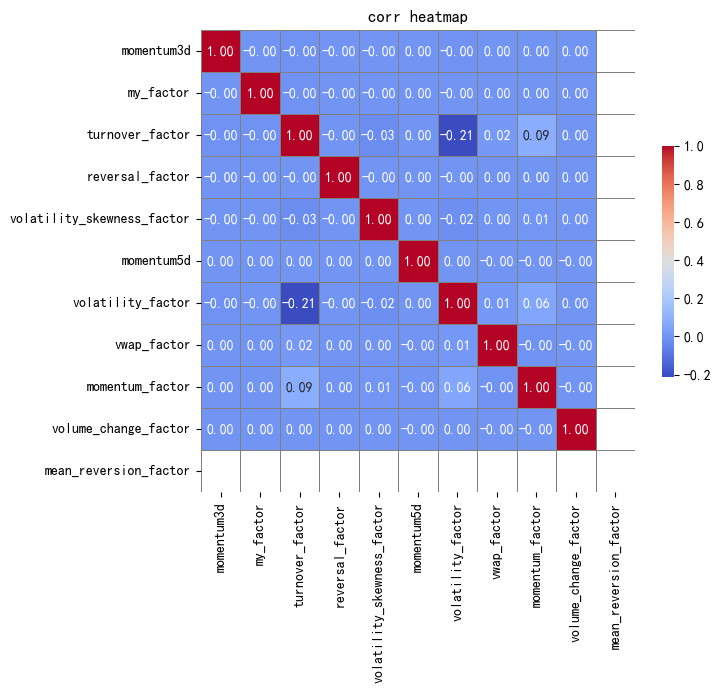

In [16]:
#正交因子相关性
plt.figure(figsize=(7,6))
sns.heatmap(result_df.corr(),annot=True,cmap='coolwarm',fmt=".2f",linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .5})
plt.title("corr heatmap")
plt.show()

In [17]:
#长表转宽表ret_data用来跑因子组合的y
ret_long.set_index(['Date','Stockcode'],inplace=True)
ret_data=ret_long.unstack(level=1)
ret_data=ret_data.swaplevel(i=0,j=1,axis=1)
ret_data.fillna(0,inplace=True)
ret_data

Stockcode,000001,000002,000063,000100,000157,000166,000301,000333,000338,000408,...,688082,688111,688126,688169,688187,688256,688303,688396,688599,688981
,ret,ret,ret,ret,ret,ret,ret,ret,ret,ret,...,ret,ret,ret,ret,ret,ret,ret,ret,ret,ret
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.008571,0.000000,0.020148,0.032374,0.036765,-0.001543,-0.018145,0.209393,-0.048780,-0.120031,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,0.015581,0.000000,0.010533,0.031359,0.053191,0.023184,0.043121,0.027508,0.136752,0.065545,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-06,-0.069735,0.000000,-0.104235,-0.097973,-0.124579,-0.098187,-0.116142,-0.267717,-0.300752,-0.140482,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-07,0.022489,0.000000,0.032727,0.056180,0.076923,0.026801,0.024499,0.111828,0.139785,0.014507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-08,-0.043988,0.000000,-0.053521,-0.053191,-0.042857,-0.070147,-0.089130,-0.181818,-0.150943,-0.124881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,-0.005685,-0.001112,0.035214,0.005587,0.008104,0.004115,-0.101718,0.013701,0.046072,0.049484,...,0.031787,0.017879,-0.004532,-0.000179,0.028243,0.003624,-0.046272,0.012125,-0.014134,0.002664
2021-12-27,-0.003177,0.003341,-0.004409,0.003704,0.014469,0.006148,0.011072,0.032346,-0.029362,0.116011,...,0.014764,-0.002367,-0.001138,-0.008073,-0.022869,0.007769,0.016608,0.011349,0.053626,0.008918


神经网络因子组合

In [83]:
def standardize(column):
    """标准化函数：(x - mean) / std"""
    if pd.api.types.is_numeric_dtype(column):  # 确保只对数值类型的数据进行操作
        mean = column.mean()
        std = column.std()
        if std == 0:
            print(f"Skipping column {column.name} because its standard deviation is 0.")
            return column  # 如果标准差为0，则返回原列数据
        return (column - mean) / std
    else:
        return column  # 非数值类型的列直接返回

# 使用 apply 方法对 DataFrame 的每一列应用 standardize 函数
result_df = result_df.groupby('Date',group_keys=False).apply(standardize)
result_df

,,momentum3d,momentum5d,my_factor,momentum_factor,volatility_factor,turnover_factor,reversal_factor,volume_change_factor,vwap_factor,mean_reversion_factor,volatility_skewness_factor
Date,Stockcode,,,,,,,,,,,
2016-01-04,000001,-0.007105,-0.010674,-0.004831,0.000558,-0.506160,-0.170674,0.010191,-0.029919,-0.021213,NaN,-0.092593
2016-01-05,000001,-0.007105,-0.010674,-0.001495,0.000558,-0.506160,-0.095317,0.010191,-0.029919,56.165864,NaN,-0.092593
2016-01-06,000001,-0.007105,-0.010674,-0.006492,0.000558,-0.506160,-0.195876,0.010191,-0.029919,70.169189,NaN,-0.092593
2016-01-07,000001,-0.007105,-0.010674,-0.019432,0.000558,-0.506160,-0.454343,0.010191,-0.029919,-63.012540,NaN,-0.092593
2016-01-08,000001,-0.113045,-0.010674,0.056307,0.000558,-0.506160,-0.052907,0.010191,-0.029919,-104.622921,NaN,-0.092593
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,688981,-0.010506,-0.034268,-0.004581,0.115176,-0.408213,0.155547,0.043122,-0.045980,0.010586,NaN,0.434982
2021-12-27,688981,-0.029120,-0.044401,-0.005641,0.021605,-0.439474,-0.018848,0.016281,-0.073899,0.002999,NaN,0.389608
2021-12-28,688981,-0.020668,-0.016911,-0.003667,-0.010513,-0.410038,0.107841,0.006979,-0.042857,0.008619,NaN,0.270007


In [86]:
factor_dfs = [
   pd.DataFrame( result_df[cod]).unstack(1).fillna(0) for cod in result_df.columns
]

In [133]:
[cod[1] for cod in factor_dfs[2].columns]

['000001',
 '000002',
 '000063',
 '000100',
 '000157',
 '000166',
 '000301',
 '000333',
 '000338',
 '000408',
 '000425',
 '000538',
 '000568',
 '000596',
 '000617',
 '000625',
 '000630',
 '000651',
 '000661',
 '000708',
 '000725',
 '000768',
 '000776',
 '000786',
 '000792',
 '000800',
 '000807',
 '000858',
 '000876',
 '000895',
 '000938',
 '000963',
 '000975',
 '000977',
 '000983',
 '000999',
 '001965',
 '001979',
 '002001',
 '002007',
 '002027',
 '002028',
 '002049',
 '002050',
 '002074',
 '002129',
 '002142',
 '002179',
 '002180',
 '002230',
 '002236',
 '002241',
 '002252',
 '002271',
 '002304',
 '002311',
 '002352',
 '002371',
 '002415',
 '002422',
 '002459',
 '002460',
 '002463',
 '002466',
 '002475',
 '002493',
 '002555',
 '002594',
 '002601',
 '002648',
 '002709',
 '002714',
 '002736',
 '002812',
 '002916',
 '002920',
 '002938',
 '003816',
 '300014',
 '300015',
 '300033',
 '300059',
 '300122',
 '300124',
 '300274',
 '300308',
 '300316',
 '300347',
 '300394',
 '300408',
 '300413',

In [88]:
returns_df=ret_data.swaplevel(i=0, j=1, axis=1).sort_index(axis=1).fillna(0)
returns_df

ret                                                    \
Stockcode     000001    000002    000063    000100    000157    000166   
Date                                                                     
2016-01-04  0.008571  0.000000  0.020148  0.032374  0.036765 -0.001543   
2016-01-05  0.015581  0.000000  0.010533  0.031359  0.053191  0.023184   
2016-01-06 -0.069735  0.000000 -0.104235 -0.097973 -0.124579 -0.098187   
2016-01-07  0.022489  0.000000  0.032727  0.056180  0.076923  0.026801   
2016-01-08 -0.043988  0.000000 -0.053521 -0.053191 -0.042857 -0.070147   
...              ...       ...       ...       ...       ...       ...   
2021-12-24 -0.005685 -0.001112  0.035214  0.005587  0.008104  0.004115   
2021-12-27 -0.003177  0.003341 -0.004409  0.003704  0.014469  0.006148   
2021-12-28 -0.026769 -0.016648 -0.010123 -0.011070 -0.014263 -0.006110   
2021-12-29  0.004584 -0.014673  0.009907  0.011194 -0.006431  0.006148   
2021-12-30 -0.022164  0.036655  0.016456 -0.005535  0.004854  0.002037   

                                                    ...                      \
Stockcode     000301    000333    000338    000408  ...    688082    688111   
Date                                                ...                       
2016-01-04 -0.018145  0.209393 -0.048780 -0.120031  ...  0.000000  0.000000   
2016-01-05  0.043121  0.027508  0.136752  0.065545  ...  0.000000  0.000000   
2016-01-06 -0.116142 -0.267717 -0.300752 -0.140482  ...  0.000000  0.000000   
2016-01-07  0.024499  0.111828  0.139785  0.014507  ...  0.000000  0.000000   
2016-01-08 -0.089130 -0.181818 -0.150943 -0.124881  ...  0.000000  0.000000   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-24 -0.101718  0.013701  0.046072  0.049484  ...  0.031787  0.017879   
2021-12-27  0.011072  0.032346 -0.029362  0.116011  ...  0.014764 -0.002367   
2021-12-28 -0.066202 -0.017211  0.000582  0.042249  ...  0.000841 -0.009722   
2021-12-29  0.004797 -0.000748 -0.015116 -0.034121  ...  0.046467  0.007575   
2021-12-30  0.007427 -0.002247 -0.022432  0.095411  ...  0.018147  0.007672   

                                                                        \
Stockcode     688126    688169    688187    688256    688303    688396   
Date                                                                     
2016-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2016-01-08  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2021-12-24 -0.004532 -0.000179  0.028243  0.003624 -0.046272  0.012125   
2021-12-27 -0.001138 -0.008073 -0.022869  0.007769  0.016608  0.011349   
2021-12-28 -0.031903 -0.002341 -0.010176 -0.023127  0.004222 -0.015742   
2021-12-29  0.014515  0.037108  0.011051  0.022563 -0.006763  0.014568   
2021-12-30 -0.003094  0.012426  0.019573  0.033696  0.055208  0.000780   

                                
Stockcode     688599    688981  
Date                            
2016-01-04  0.000000  0.000000  
2016-01-05  0.000000  0.000000  
2016-01-06  0.000000  0.000000  
2016-01-07  0.000000  0.000000  
2016-01-08  0.000000  0.000000  
...              ...       ...  
2021-12-24 -0.014134  0.002664  
2021-12-27  0.053626  0.008918  
2021-12-28 -0.014654 -0.008275  
2021-12-29 -0.015536  0.003034  
2021-12-30  0.046129  0.001891  

[1460 rows x 288 columns]

In [89]:
import torch
import pandas as pd
import numpy as np
num_factors=len(factor_dfs)
factor_tensor=torch.stack([torch.tensor(df.values,dtype=torch.float32) for df in factor_dfs],dim=-1)
returns_tensor=torch.tensor(returns_df.values,dtype=torch.float32)


In [90]:
factor_tensor.shape

torch.Size([1460, 288, 11])

In [91]:
returns_tensor.shape

torch.Size([1460, 288])

In [92]:
# 调整因子张量形状 [1460 * 288, 11]
x = factor_tensor.reshape(-1, 11)  # 输入特征形状: [420,480, 11]

# 调整收益率张量形状 [1460 * 288, 1]
y = returns_tensor.reshape(-1, 1)  # 目标形状: [420,480, 1]

In [94]:
y

tensor([[0.0086],
        [0.0000],
        [0.0201],
        ...,
        [0.0008],
        [0.0461],
        [0.0019]])

In [95]:
class FactorWeightModel(torch.nn.Module):
    def __init__(self,input_dim=num_factors):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
    def forward(self,x):
        return self.net(x)

In [96]:
def correlation_loss(pred,target):
    pred_mean=pred-pred.mean()
    target_mean=target-target.mean()
    cov=(pred_mean*target_mean).mean()
    pred_std=torch.sqrt((pred_mean**2).mean())
    target_std=torch.sqrt((target_mean**2).mean())
    return -cov/(pred_std*target_std)
    

In [97]:
model=FactorWeightModel()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
criterion=correlation_loss


In [ ]:
epochs=1000
for epoch in range(epochs):
    optimizer.zero_grad()
    pred=model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")       
    

Epoch 0, Loss: -0.0037079898174852133
Epoch 100, Loss: -0.18733131885528564
Epoch 200, Loss: -0.23096920549869537
Epoch 300, Loss: -0.27194374799728394
Epoch 400, Loss: -0.2637979984283447
Epoch 500, Loss: -0.28604361414909363
Epoch 600, Loss: -0.27250805497169495
Epoch 700, Loss: -0.2922876179218292
Epoch 800, Loss: -0.3017708361148834
Epoch 900, Loss: -0.30075618624687195


AttributeError: 'FactorWeightModel' object has no attribute 'linear'

In [100]:
# 训练完成后查看权重
print("第一层权重（输入因子权重）:", model.net[0].weight.data)
print("第一层偏置:", model.net[0].bias.data)  # 若有偏置项
print("第二层权重（隐藏层权重）:", model.net[2].weight.data)
print("第二层偏置:", model.net[2].bias.data)  # 若有偏置项

第一层权重（输入因子权重）: tensor([[ 4.6041e-01, -2.9996e-01,  2.9890e-02,  1.2973e-01,  8.4827e-03,
         -1.1275e-01, -1.4141e-01, -2.4162e-01, -5.5838e-03, -2.3827e-01,
         -1.0453e-01],
        [-5.3393e-01,  2.5820e-01,  1.8630e-01, -1.3990e-01,  9.7178e-02,
          5.4828e-02, -2.3365e-02,  6.2459e-02, -1.1568e-02, -2.4942e-01,
          1.0370e-01],
        [ 4.4457e-01,  3.9555e-01,  3.2589e-01,  1.2796e-01, -2.6674e-01,
          2.1201e-02,  3.8786e-01, -3.0442e-01,  5.3162e-02,  2.8389e-01,
          5.5970e-02],
        [-1.9144e-01,  5.3782e-01,  6.0316e-02,  1.6272e-01, -6.5375e-02,
          7.5533e-02,  2.1208e-01,  2.1726e-03,  6.3689e-03,  7.7990e-02,
         -9.5925e-03],
        [ 5.6501e-01,  2.0459e-01,  4.8634e-02,  2.2265e-01,  5.3986e-02,
          3.9535e-02,  1.5546e-02, -3.9563e-04, -4.2553e-02, -2.1403e-01,
          1.1276e-02],
        [-4.7447e-01, -2.4148e-01,  6.1957e-02, -1.6473e-02,  8.9499e-02,
         -2.3156e-02,  2.0902e-01,  1.0899e-01, -4.7020e

In [114]:
model.net[0].weight.data.shape

torch.Size([32, 11])

In [116]:
x.shape

torch.Size([420480, 11])

In [110]:
# 预测收益率
with torch.no_grad():
    predicted_returns = model(x).view_as(returns_tensor)

In [113]:
predicted_returns

tensor([[-0.6030, -0.6009, -0.5962,  ..., -0.6009, -0.6009, -0.6009],
        [-0.6973, -0.6009, -0.5928,  ..., -0.6009, -0.6009, -0.6009],
        [-0.7150, -0.6009, -0.5926,  ..., -0.6009, -0.6009, -0.6009],
        ...,
        [-0.6085, -0.6037, -0.6044,  ..., -0.6022, -0.6046, -0.6030],
        [-0.6097, -0.6046, -0.6032,  ..., -0.6024, -0.6042, -0.6034],
        [-0.6051, -0.6051, -0.6035,  ..., -0.6029, -0.6017, -0.6038]])

In [118]:
# 手动分步计算
T, N = 1460, 288
with torch.no_grad():
    # 第一层计算（线性变换 + ReLU）                     # 输入形状 [T*N, 11]
    hidden_output = torch.mm(x, model.net[0].weight.t()) + model.net[0].bias  # [T*N, 32]
    hidden_output = torch.relu(hidden_output)           # ReLU激活
    
    # 第二层计算（线性变换）
    final_output = torch.mm(hidden_output, model.net[2].weight.t()) + model.net[2].bias  # [T*N, 1]
    
    # 恢复形状
    weighted_factor_matrix = final_output.view(T, N)    # 形状 [T, N]

print("手动计算的加权因子矩阵形状:", weighted_factor_matrix.shape)

手动计算的加权因子矩阵形状: torch.Size([1460, 288])


In [123]:
newret=weighted_factor_matrix
newret

tensor([[-0.6030, -0.6009, -0.5962,  ..., -0.6009, -0.6009, -0.6009],
        [-0.6973, -0.6009, -0.5928,  ..., -0.6009, -0.6009, -0.6009],
        [-0.7150, -0.6009, -0.5926,  ..., -0.6009, -0.6009, -0.6009],
        ...,
        [-0.6085, -0.6037, -0.6044,  ..., -0.6022, -0.6046, -0.6030],
        [-0.6097, -0.6046, -0.6032,  ..., -0.6024, -0.6042, -0.6034],
        [-0.6051, -0.6051, -0.6035,  ..., -0.6029, -0.6017, -0.6038]])

In [134]:
newret1=pd.DataFrame(newret)
newret1.index=factor_dfs[2].index
newret1.columns=[cod[1] for cod in factor_dfs[2].columns]
newret1

,000001,000002,000063,000100,000157,000166,000301,000333,000338,000408,...,688082,688111,688126,688169,688187,688256,688303,688396,688599,688981
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.602962,-0.600948,-0.596194,-0.610127,-0.542619,-0.602932,-0.600807,-0.593689,-0.510559,-0.606960,...,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948
2016-01-05,-0.697281,-0.600948,-0.592829,-0.604981,-0.531407,-0.603047,-0.601251,-0.572683,-0.496923,-0.619680,...,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948
2016-01-06,-0.714958,-0.600948,-0.592568,-0.615379,-0.534174,-0.603795,-0.602766,-0.567506,-0.519446,-0.596735,...,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948
2016-01-07,-0.538250,-0.600948,-0.610088,-0.578276,-0.547892,-0.599539,-0.596359,-0.565352,-0.427188,-0.616150,...,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948
2016-01-08,-0.512791,-0.600948,-0.589771,-0.622169,-0.523014,-0.601095,-0.596799,-0.592269,-0.526530,-0.564504,...,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948,-0.600948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,-0.604457,-0.604064,-0.604141,-0.603738,-0.603391,-0.601438,-0.599634,-0.604697,-0.609916,-0.603051,...,-0.600728,-0.604619,-0.601659,-0.601017,-0.606535,-0.602209,-0.603088,-0.603862,-0.602176,-0.603669
2021-12-27,-0.605741,-0.604840,-0.606817,-0.606375,-0.602560,-0.600668,-0.602866,-0.606767,-0.608698,-0.604861,...,-0.600821,-0.603874,-0.600990,-0.601734,-0.607518,-0.601337,-0.601001,-0.601781,-0.603678,-0.603091
2021-12-28,-0.608471,-0.603736,-0.604402,-0.605964,-0.603022,-0.600946,-0.598122,-0.608031,-0.606876,-0.602244,...,-0.600760,-0.604496,-0.600746,-0.601912,-0.603416,-0.601425,-0.599334,-0.602192,-0.604599,-0.603016


In [148]:
newret2=returns_df['ret']*newret1
newret2

Stockcode,000001,000002,000063,000100,000157,000166,000301,000333,000338,000408,...,688082,688111,688126,688169,688187,688256,688303,688396,688599,688981
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.005168,-0.000000,-0.012012,-0.019752,-0.019949,0.000930,0.010902,-0.124315,0.024905,0.072854,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2016-01-05,-0.010864,-0.000000,-0.006244,-0.018972,-0.028266,-0.013981,-0.025927,-0.015753,-0.067955,-0.040617,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2016-01-06,0.049858,-0.000000,0.061766,0.060291,0.066547,0.059285,0.070006,0.151931,0.156224,0.083831,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2016-01-07,-0.012105,-0.000000,-0.019967,-0.032487,-0.042146,-0.016068,-0.014610,-0.063222,-0.059714,-0.008938,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2016-01-08,0.022557,-0.000000,0.031565,0.033094,0.022415,0.042165,0.053193,0.107685,0.079476,0.070496,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,0.003437,0.000672,-0.021274,-0.003373,-0.004890,-0.002475,0.060993,-0.008285,-0.028100,-0.029841,...,-0.019095,-0.010810,0.002727,0.000107,-0.017130,-0.002182,0.027906,-0.007322,0.008511,-0.001608
2021-12-27,0.001924,-0.002021,0.002676,-0.002246,-0.008719,-0.003693,-0.006675,-0.019627,0.017873,-0.070170,...,-0.008870,0.001430,0.000684,0.004858,0.013893,-0.004672,-0.009981,-0.006830,-0.032373,-0.005379
2021-12-28,0.016288,0.010051,0.006119,0.006708,0.008601,0.003672,0.039597,0.010465,-0.000353,-0.025444,...,-0.000505,0.005877,0.019165,0.001409,0.006140,0.013909,-0.002530,0.009480,0.008860,0.004990


In [158]:
"""from collections import OrderedDict
orig=[x[0] for x in df_swapped.columns]
uniqueorder=list(OrderedDict.fromkeys(orig))
uniqueorder"""

'from collections import OrderedDict\norig=[x[0] for x in df_swapped.columns]\nuniqueorder=list(OrderedDict.fromkeys(orig))\nuniqueorder'

In [19]:
"""from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(df_swapped, ret_data, test_size=0.2, random_state=42)

X_train = X_train.sort_values(by='Date')
X_test = X_test.sort_values(by='Date')
y_train = y_train.sort_values(by='Date')
y_test = y_test.sort_values(by='Date')

# 构建神经网络模型
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# 译模型
model.compile(loss='mean_squared_error', optimizer='adam')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# 评估模型
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
y_pred_test = model.predict(X_test)
y_pred_test=pd.DataFrame(y_pred_test)
y_pred_test"""

'from sklearn.model_selection import train_test_split\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\n\n# 划分训练集和测试集\nX_train, X_test, y_train, y_test = train_test_split(df_swapped, ret_data, test_size=0.2, random_state=42)\n\nX_train = X_train.sort_values(by=\'Date\')\nX_test = X_test.sort_values(by=\'Date\')\ny_train = y_train.sort_values(by=\'Date\')\ny_test = y_test.sort_values(by=\'Date\')\n\n# 构建神经网络模型\nmodel = Sequential()\nmodel.add(Dense(64, input_dim=X_train.shape[1], activation=\'relu\'))\nmodel.add(Dense(32, activation=\'relu\'))\nmodel.add(Dense(1, activation=\'linear\'))\n\n# 译模型\nmodel.compile(loss=\'mean_squared_error\', optimizer=\'adam\')\n\n# 训练模型\nmodel.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)\n\n# 评估模型\nloss = model.evaluate(X_test, y_test)\nprint(f"Test Loss: {loss}")\ny_pred_test = model.predict(X_test)\ny_pred_test=pd.DataFrame(y_pred_test)\ny_pred_test'

In [157]:
"""X=df_swapped
y=ret_data
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_test"""

'X=df_swapped\ny=ret_data\nsplit_idx = int(len(X)*0.8)\nX_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]\ny_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]\nX_test'

In [155]:
"""#一个code一张表 一张表丢进模型得到一列收益率
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def nnmodel(code,base_df):
    # 划分训练集和测试集
    X=df_swapped[code]
    y=ret_data[code]
   # 划分数据集（保持时序）
    split_idx = int(len(X)*0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    # 构建神经网络模型
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # 译模型
    model.compile(loss='mean_squared_error', optimizer='adam')

    # 训练模型
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # 评估模型
    loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    y_pred_test = model.predict(X_test)
    return pd.concat([base_df,pd.DataFrame(y_pred_test)],axis=1)
    
newret=pd.DataFrame()
for code in uniqueorder:
    newret=nnmodel(code,newret)
newret"""

'#一个code一张表 一张表丢进模型得到一列收益率\nfrom sklearn.model_selection import train_test_split\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\ndef nnmodel(code,base_df):\n    # 划分训练集和测试集\n    X=df_swapped[code]\n    y=ret_data[code]\n   # 划分数据集（保持时序）\n    split_idx = int(len(X)*0.8)\n    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]\n    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]\n    # 构建神经网络模型\n    model = Sequential()\n    model.add(Dense(64, input_dim=X_train.shape[1], activation=\'relu\'))\n    model.add(Dense(32, activation=\'relu\'))\n    model.add(Dense(1, activation=\'linear\'))\n\n    # 译模型\n    model.compile(loss=\'mean_squared_error\', optimizer=\'adam\')\n\n    # 训练模型\n    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)\n\n    # 评估模型\n    loss = model.evaluate(X_test, y_test)\n    print(f"Test Loss: {loss}")\n    y_pred_test = model.predict(X_test)\n    return pd.concat([base_df,pd.DataFrame(y_pred_te

In [156]:
"""#神经网络因子组合后得到因子矩阵
newret['Date']=X_test.index
newret.set_index('Date',inplace=True)
newret1=newret
newret.columns=uniqueorder
newret"""

"#神经网络因子组合后得到因子矩阵\nnewret['Date']=X_test.index\nnewret.set_index('Date',inplace=True)\nnewret1=newret\nnewret.columns=uniqueorder\nnewret"

模型跑完得到的是收益率预测值矩阵还是因子值加权组合矩阵？

In [160]:
newret_long = (
    newret1.stack()                     # 堆叠所有股票代码列
    .reset_index()                 # 重置索引
    .rename(columns={
        "level_1": "Stockcode", 
        0: "new_ret"                # 假设目标列名是Value（根据实际字段调整）
    })
    .set_index(["Date", "Stockcode"])  # 设置双索引
    .sort_index()                  # 按索引排序（可选）
)
newret_long

new_ret
Date       Stockcode          
2016-01-04 000001    -0.602962
           000002    -0.600948
           000063    -0.596194
           000100    -0.610127
           000157    -0.542619
...                        ...
2021-12-30 688256    -0.601681
           688303    -0.601710
           688396    -0.602905
           688599    -0.601715
           688981    -0.603784

[420480 rows x 1 columns]

In [161]:
def weight_scaling(data,col):
    """
    对因子权重进行缩放 使得每天的权重绝对值之和等于1。

    """
    data['factor_abs'] = data[col].abs()
    data['factor_abs_sum'] = data.groupby('Date')['factor_abs'].transform('sum')
    data[col] = data[col] / data['factor_abs_sum']
    data.drop(columns=['factor_abs', 'factor_abs_sum'],inplace=True)
    return data
#col="momentum3d"
#factordata1=weight_scaling(pd.DataFrame(result_df[col]),col)
#factordata1
def process_outlier(data, col,lower_quantile=0.1, upper_quantile=0.9):
    """
    对因子值进行截面处理 除每个日期和因子组合下的极端值 如1%和99%分位数之外的值 。
    """
    lower = data.groupby(['Date'])[col].transform(lambda x: x.quantile(lower_quantile))
    upper = data.groupby(['Date'])[col].transform(lambda x: x.quantile(upper_quantile))
    mask = (data[col] >= lower) & (data[col] <= upper)
    data[col] = data[col].where(mask, np.nan)
    #data = data.dropna(subset=[col])
    data = data.fillna(0)
    return data
#col="momentum3d"
#processed_data = process_outlier(pd.DataFrame(result_df[col]),col)
#processed_data
def market_neutralization(data,col):
    """
    对因子值进行市场中性化处理 使得每个截面上的信号加总为0。
    """
    mean_values = data.groupby(['Date'])[col].transform('mean')
    data[col] = data[col] - mean_values
    return data
#markneut_data = market_neutralization(pd.DataFrame(result_df[col]),col)
#markneut_data

In [162]:
newret_long = weight_scaling(newret_long, 'new_ret').fillna(0)
newret_long= process_outlier(newret_long, 'new_ret').fillna(0)
newret_long = market_neutralization(newret_long,'new_ret').fillna(0)
newret_long

new_ret
Date       Stockcode          
2016-01-04 000001    -0.000784
           000002    -0.000772
           000063    -0.000744
           000100    -0.000826
           000157     0.002764
...                        ...
2021-12-30 688256    -0.000691
           688303    -0.000691
           688396    -0.000698
           688599    -0.000691
           688981    -0.000703

[420480 rows x 1 columns]

In [169]:
newret1=newret_long.unstack(1)
#newret1 = newret1.swaplevel(i=0, j=1, axis=1).sort_index(axis=1).fillna(0)
newret1

new_ret                                                    \
Stockcode     000001    000002    000063    000100    000157    000166   
Date                                                                     
2016-01-04 -0.000784 -0.000772 -0.000744 -0.000826  0.002764 -0.000784   
2016-01-05  0.002757 -0.000766 -0.000719 -0.000790  0.002757 -0.000779   
2016-01-06  0.002751 -0.000763 -0.000714 -0.000848  0.002751 -0.000780   
2016-01-07  0.002786 -0.000780  0.002786 -0.000646  0.002786 -0.000772   
2016-01-08  0.002704 -0.000749 -0.000685  0.002704  0.002704 -0.000750   
...              ...       ...       ...       ...       ...       ...   
2021-12-24 -0.000705 -0.000703 -0.000704 -0.000701 -0.000699  0.002772   
2021-12-27  0.002772 -0.000711  0.002772  0.002772 -0.000697  0.002772   
2021-12-28  0.002772 -0.000703 -0.000707  0.002772 -0.000699 -0.000687   
2021-12-29  0.002771 -0.000708 -0.000700 -0.000707 -0.000701 -0.000691   
2021-12-30 -0.000711 -0.000710 -0.000701 -0.000691 -0.000701 -0.000690   

                                                    ...                      \
Stockcode     000301    000333    000338    000408  ...    688082    688111   
Date                                                ...                       
2016-01-04 -0.000771 -0.000730  0.002764 -0.000808  ... -0.000772 -0.000772   
2016-01-05 -0.000768 -0.000601  0.002757  0.002757  ... -0.000766 -0.000766   
2016-01-06 -0.000774 -0.000568  0.002751 -0.000739  ... -0.000763 -0.000763   
2016-01-07 -0.000753 -0.000569  0.002786  0.002786  ... -0.000780 -0.000780   
2016-01-08 -0.000725 -0.000699  0.002704 -0.000539  ... -0.000749 -0.000749   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-24  0.002772 -0.000707  0.002772 -0.000697  ...  0.002772 -0.000706   
2021-12-27 -0.000699  0.002772  0.002772 -0.000711  ...  0.002772 -0.000705   
2021-12-28  0.002772  0.002772  0.002772 -0.000694  ...  0.002772 -0.000707   
2021-12-29  0.002771  0.002771 -0.000710 -0.000694  ...  0.002771 -0.000706   
2021-12-30  0.002771 -0.000714 -0.000711  0.002771  ... -0.000700 -0.000694   

                                                                        \
Stockcode     688126    688169    688187    688256    688303    688396   
Date                                                                     
2016-01-04 -0.000772 -0.000772 -0.000772 -0.000772 -0.000772 -0.000772   
2016-01-05 -0.000766 -0.000766 -0.000766 -0.000766 -0.000766 -0.000766   
2016-01-06 -0.000763 -0.000763 -0.000763 -0.000763 -0.000763 -0.000763   
2016-01-07 -0.000780 -0.000780 -0.000780 -0.000780 -0.000780 -0.000780   
2016-01-08 -0.000749 -0.000749 -0.000749 -0.000749 -0.000749 -0.000749   
...              ...       ...       ...       ...       ...       ...   
2021-12-24 -0.000689  0.002772  0.002772 -0.000692 -0.000698 -0.000702   
2021-12-27 -0.000688 -0.000693  0.002772 -0.000690 -0.000688 -0.000693   
2021-12-28  0.002772 -0.000693 -0.000701 -0.000690  0.002772 -0.000694   
2021-12-29 -0.000689 -0.000705 -0.000701 -0.000695  0.002771 -0.000695   
2021-12-30  0.002771 -0.000697 -0.000696 -0.000691 -0.000691 -0.000698   

                                
Stockcode     688599    688981  
Date                            
2016-01-04 -0.000772 -0.000772  
2016-01-05 -0.000766 -0.000766  
2016-01-06 -0.000763 -0.000763  
2016-01-07 -0.000780 -0.000780  
2016-01-08 -0.000749 -0.000749  
...              ...       ...  
2021-12-24 -0.000692 -0.000701  
2021-12-27 -0.000704 -0.000701  
2021-12-28 -0.000708 -0.000699  
2021-12-29 -0.000705 -0.000701  
2021-12-30 -0.000691 -0.000703  

[1460 rows x 288 columns]

In [170]:
newret2=returns_df['ret']*newret1
newret2

new_ret                                                        \
Stockcode     000001        000002    000063    000100    000157    000166   
Date                                                                         
2016-01-04 -0.000007 -0.000000e+00 -0.000015 -0.000027  0.000102  0.000001   
2016-01-05  0.000043 -0.000000e+00 -0.000008 -0.000025  0.000147 -0.000018   
2016-01-06 -0.000192 -0.000000e+00  0.000074  0.000083 -0.000343  0.000077   
2016-01-07  0.000063 -0.000000e+00  0.000091 -0.000036  0.000214 -0.000021   
2016-01-08 -0.000119 -0.000000e+00  0.000037 -0.000144 -0.000116  0.000053   
...              ...           ...       ...       ...       ...       ...   
2021-12-24  0.000004  7.821242e-07 -0.000025 -0.000004 -0.000006  0.000011   
2021-12-27 -0.000009 -2.373927e-06 -0.000012  0.000010 -0.000010  0.000017   
2021-12-28 -0.000074  1.170471e-05  0.000007 -0.000031  0.000010  0.000004   
2021-12-29  0.000013  1.039042e-05 -0.000007 -0.000008  0.000005 -0.000004   
2021-12-30  0.000016 -2.603784e-05 -0.000012  0.000004 -0.000003 -0.000001   

                                                    ...                      \
Stockcode     000301    000333    000338    000408  ...    688082    688111   
Date                                                ...                       
2016-01-04  0.000014 -0.000153 -0.000135  0.000097  ... -0.000000 -0.000000   
2016-01-05 -0.000033 -0.000017  0.000377  0.000181  ... -0.000000 -0.000000   
2016-01-06  0.000090  0.000152 -0.000827  0.000104  ... -0.000000 -0.000000   
2016-01-07 -0.000018 -0.000064  0.000389  0.000040  ... -0.000000 -0.000000   
2016-01-08  0.000065  0.000127 -0.000408  0.000067  ... -0.000000 -0.000000   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-24 -0.000282 -0.000010  0.000128 -0.000035  ...  0.000088 -0.000013   
2021-12-27 -0.000008  0.000090 -0.000081 -0.000082  ...  0.000041  0.000002   
2021-12-28 -0.000183 -0.000048  0.000002 -0.000029  ...  0.000002  0.000007   
2021-12-29  0.000013 -0.000002  0.000011  0.000024  ...  0.000129 -0.000005   
2021-12-30  0.000021  0.000002  0.000016  0.000264  ... -0.000013 -0.000005   

                                                                      \
Stockcode         688126        688169    688187    688256    688303   
Date                                                                   
2016-01-04 -0.000000e+00 -0.000000e+00 -0.000000 -0.000000 -0.000000   
2016-01-05 -0.000000e+00 -0.000000e+00 -0.000000 -0.000000 -0.000000   
2016-01-06 -0.000000e+00 -0.000000e+00 -0.000000 -0.000000 -0.000000   
2016-01-07 -0.000000e+00 -0.000000e+00 -0.000000 -0.000000 -0.000000   
2016-01-08 -0.000000e+00 -0.000000e+00 -0.000000 -0.000000 -0.000000   
...                  ...           ...       ...       ...       ...   
2021-12-24  3.123679e-06 -4.949462e-07  0.000078 -0.000003  0.000032   
2021-12-27  7.834973e-07  5.592396e-06 -0.000063 -0.000005 -0.000011   
2021-12-28 -8.842628e-05  1.621162e-06  0.000007  0.000016  0.000012   
2021-12-29 -1.000000e-05 -2.614329e-05 -0.000008 -0.000016 -0.000019   
2021-12-30 -8.573756e-06 -8.661906e-06 -0.000014 -0.000023 -0.000038   

                                              
Stockcode         688396    688599    688981  
Date                                          
2016-01-04 -0.000000e+00 -0.000000 -0.000000  
2016-01-05 -0.000000e+00 -0.000000 -0.000000  
2016-01-06 -0.000000e+00 -0.000000 -0.000000  
2016-01-07 -0.000000e+00 -0.000000 -0.000000  
2016-01-08 -0.000000e+00 -0.000000 -0.000000  
...                  ...       ...       ...  
2021-12-24 -8.511368e-06  0.000010 -0.000002  
2021-12-27 -7.864915e-06 -0.000038 -0.000006  
2021-12-28  1.092756e-05  0.000010  0.000006  
2021-12-29 -1.013205e-05  0.000011 -0.000002  
2021-12-30 -5.446278e-07 -0.000032 -0.000001  

[1460 rows x 288 columns]

In [171]:
warnings.filterwarnings("ignore")
def pnl_index(ret_series,factor):
    """
    计算收益的PNL指数。
    
    :param ret_series: 包含每日收益率的Pandas Series
    :return: 包含年化收益率、年化波动率、夏普比率和最大回撤的DataFrame
    """
    trade_day_count = len(ret_series)
    
    # 年化收益率
    AR = ret_series.sum() * trade_day_count / len(ret_series)
    
    # 年化波动率
    AV = ret_series.std() * math.sqrt(trade_day_count)
    
    # 夏普比率
    SR = ret_series.mean() / ret_series.std() * math.sqrt(trade_day_count)
    
    # 最大回撤
    # 计算累积净值
    cumulative_returns =1 + ret_series.cumsum()
    # 计算累积最大值
    cumulative_max = cumulative_returns.cummax()
    
    # 计算回撤
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    
    # 找出最大回撤
    max_drawdown = (drawdown.min())
    result_data = [
        {"index_name": f"Annualized Return {factor}", "index_value": AR},
        {"index_name": f"Annualized Volatility {factor}", "index_value": AV},
        {"index_name": f"Sharpe Ratio {factor}", "index_value": SR},
        {"index_name": f"Maximum Drawdown {factor}", "index_value": max_drawdown}
    ]
    
    result = pd.DataFrame(result_data)
    
    return result

#res=pnl_index(y_pred_test,'after nn model')
res=pnl_index(newret2.mean(axis=1),'after nn model')
res

,index_name,index_value
0,Annualized Return after nn model,0.000211
1,Annualized Volatility after nn model,0.001574
2,Sharpe Ratio after nn model,0.133936
3,Maximum Drawdown after nn model,-0.001239


In [172]:
newret2.mean(axis=1)

Date
2016-01-04   -1.428204e-05
2016-01-05   -5.923556e-04
2016-01-06   -5.457399e-05
2016-01-07    5.039240e-05
2016-01-08   -1.700497e-04
                  ...     
2021-12-24   -1.674534e-06
2021-12-27    6.813764e-07
2021-12-28   -3.503441e-06
2021-12-29   -2.197197e-06
2021-12-30    3.980910e-06
Length: 1460, dtype: float64

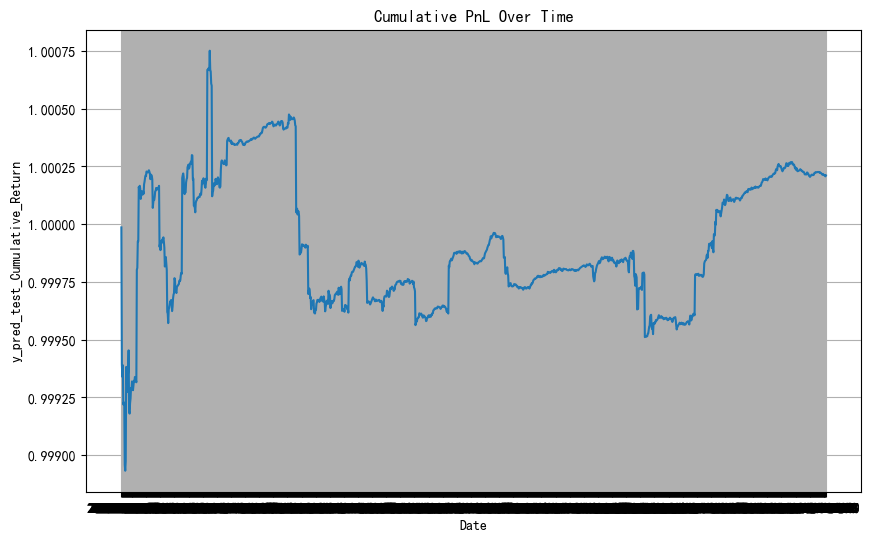

In [173]:
cumulative_returns =1 + (newret2.mean(axis=1)).cumsum() 
  # 可视化累计PnL
plt.figure(figsize=(10, 6))
plt.plot(newret2.index,cumulative_returns)
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('y_pred_test_Cumulative_Return')
plt.grid(True)
plt.show()

In [174]:
cumulative_returns

Date
2016-01-04    0.999986
2016-01-05    0.999393
2016-01-06    0.999339
2016-01-07    0.999389
2016-01-08    0.999219
                ...   
2021-12-24    1.000212
2021-12-27    1.000212
2021-12-28    1.000209
2021-12-29    1.000207
2021-12-30    1.000211
Length: 1460, dtype: float64

数据处理

In [ ]:
def weight_scaling(data,col):
    """
    对因子权重进行缩放 使得每天的权重绝对值之和等于1。

    """
    data['factor_abs'] = data[col].abs()
    data['factor_abs_sum'] = data.groupby('Date')['factor_abs'].transform('sum')
    data[col] = data[col] / data['factor_abs_sum']
    data.drop(columns=['factor_abs', 'factor_abs_sum'],inplace=True)
    return data
#col="momentum3d"
#factordata1=weight_scaling(pd.DataFrame(result_df[col]),col)
#factordata1
def process_outlier(data, col,lower_quantile=0.1, upper_quantile=0.9):
    """
    对因子值进行截面处理 除每个日期和因子组合下的极端值 如1%和99%分位数之外的值 。
    """
    lower = data.groupby(['Date'])[col].transform(lambda x: x.quantile(lower_quantile))
    upper = data.groupby(['Date'])[col].transform(lambda x: x.quantile(upper_quantile))
    mask = (data[col] >= lower) & (data[col] <= upper)
    data[col] = data[col].where(mask, np.nan)
    #data = data.dropna(subset=[col])
    data = data.fillna(0)
    return data
#col="momentum3d"
#processed_data = process_outlier(pd.DataFrame(result_df[col]),col)
#processed_data
def market_neutralization(data,col):
    """
    对因子值进行市场中性化处理 使得每个截面上的信号加总为0。
    """
    mean_values = data.groupby(['Date'])[col].transform('mean')
    data[col] = data[col] - mean_values
    return data
#markneut_data = market_neutralization(pd.DataFrame(result_df[col]),col)
#markneut_data

In [ ]:
columns_to_scale = result_df.columns.difference(['Stockcode', 'Date'])
for col in columns_to_scale:
    result_df1 = weight_scaling(result_df, col).fillna(0)
    result_df1 = process_outlier(result_df, col).fillna(0)
    result_df1 = market_neutralization(result_df, col).fillna(0)
#数据处理后的df1    
result_df1

momentum3d  my_factor  turnover_factor  reversal_factor  \
Stockcode Date                                                                  
000001    2016-01-04    0.000000   0.000000         0.000000        -0.012278   
          2016-01-05    0.000000   0.000000         0.000000        -0.012334   
          2016-01-06    0.000000   0.011596         0.011040        -0.011700   
          2016-01-07    0.000000   0.000000         0.000000         0.000000   
          2016-01-08    0.000000   0.000000         0.000000         0.000000   
...                          ...        ...              ...              ...   
688981    2021-12-24   -0.006382   0.000640         0.004011         0.003399   
          2021-12-27   -0.002348  -0.000205         0.001042         0.003559   
          2021-12-28   -0.002346   0.002225         0.002768        -0.000291   
          2021-12-29    0.004539  -0.000538         0.002448         0.000822   
          2021-12-30    0.003589   0.004409         0.006312        -0.000715   

                      volatility_skewness_factor  momentum5d  \
Stockcode Date                                                 
000001    2016-01-04                    0.013133   -0.014035   
          2016-01-05                    0.012895   -0.013809   
          2016-01-06                    0.012696   -0.013237   
          2016-01-07                    0.015706    0.000000   
          2016-01-08                    0.015212   -0.014581   
...                                          ...         ...   
688981    2021-12-24                    0.004037   -0.001540   
          2021-12-27                    0.003870   -0.003641   
          2021-12-28                    0.002308   -0.003804   
          2021-12-29                    0.005136   -0.000352   
          2021-12-30                    0.005967   -0.001595   

                      volatility_factor  vwap_factor  momentum_factor  \
Stockcode Date                                                          
000001    2016-01-04            0.00000     0.000000        -0.006471   
          2016-01-05            0.00000     0.000000        -0.008235   
          2016-01-06            0.00000     0.000000        -0.008239   
          2016-01-07            0.00000     0.000000        -0.005801   
          2016-01-08            0.00000     0.000000        -0.003860   
...                                 ...          ...              ...   
688981    2021-12-24            0.00000    -0.004941         0.008031   
          2021-12-27            0.00000    -0.002724         0.007910   
          2021-12-28            0.00000    -0.003548         0.005459   
          2021-12-29           -0.00808    -0.003260         0.006431   
          2021-12-30            0.00000    -0.006534         0.005697   

                      volume_change_factor  mean_reversion_factor  
Stockcode Date                                                     
000001    2016-01-04              0.000000                    0.0  
          2016-01-05              0.000000                    0.0  
          2016-01-06              0.000000                    0.0  
          2016-01-07              0.000000                    0.0  
          2016-01-08              0.000000                    0.0  
...                                    ...                    ...  
688981    2021-12-24              0.004558                    0.0  
          2021-12-27             -0.001458                    0.0  
          2021-12-28              0.000137                    0.0  
          2021-12-29             -0.000428                    0.0  
          2021-12-30              0.007305                    0.0  

[363036 rows x 11 columns]

In [ ]:
res=pnl_index(newret.mean(axis=1),'after nn model')
res

,index_name,index_value
0,Annualized Return after nn model,-1.269804e-10
1,Annualized Volatility after nn model,4.434483e-10
2,Sharpe Ratio after nn model,-2.863477e-01
3,Maximum Drawdown after nn model,0.000000e+00


In [ ]:
#df1宽表转长表factor_data
result_df1.reset_index(inplace=True)
factor_data=[]
columns_to_scale = result_df1.columns.difference(['Stockcode', 'Date'])
for col in columns_to_scale:
    x=result_df1.loc[:,['Date','Stockcode',col]]
    x.rename(columns={col:'factor_value'},inplace=True)
    x['factor_name']=col
    factor_data.append(x)
factor_data=pd.concat(factor_data,axis=0)
factor_data

,Date,Stockcode,factor_value,factor_name
0,2016-01-04,000001,0.000000,mean_reversion_factor
1,2016-01-05,000001,0.000000,mean_reversion_factor
2,2016-01-06,000001,0.000000,mean_reversion_factor
3,2016-01-07,000001,0.000000,mean_reversion_factor
4,2016-01-08,000001,0.000000,mean_reversion_factor
...,...,...,...,...
363031,2021-12-24,688981,-0.004941,vwap_factor
363032,2021-12-27,688981,-0.002724,vwap_factor
363033,2021-12-28,688981,-0.003548,vwap_factor
363034,2021-12-29,688981,-0.003260,vwap_factor


In [ ]:
def industry_neutralization(data):
    """
    对因子值进行行业中性化处理 使得每个行业内部的信号加总为0 缺少industry数据
    
    :param data: 包含日期、因子名称、因子值和行业信息的DataFrame
    :return: 处理后的DataFrame
    """
    # 按日期、因子名称和行业分组计算每个截面的均值 
    mean_values = data.groupby(['date', 'factor_name', 'industry'])['factor_value'].transform('mean')
    
    # 将原始信号减去均值
    data['factor_value'] = data['factor_value'] - mean_values
    
    return data

# 示例用法
# 假设data是一个包含'date'（日期）、'factor_name'（因子名称）、'factor_value'（因子值）和'industry'（行业）列的DataFrame
# neutralized_data = industry_neutralization(data)

In [ ]:
def neutralization(group):
        # 先对市值取对数降低数量级 缺少market_cap数据
        group['log_market_cap'] = np.log(group['market_cap'])
        
        # 提取对数值和因子值 如果原始数组是 [1, 2, 3]，则转换后的数组将是 [[1], [2], [3]]。
        X = group['log_market_cap'].values.reshape(-1, 1)
        y = group['factor_value']
        
        # 创建线性回归模型并拟合数据
        model = LinearRegression()
        model.fit(X, y)
        
        # 计算残差作为新的因子值
        group['factor_value'] = y - model.predict(X)
        
        # 删除临时列
        group.drop(columns=['log_market_cap'], inplace=True)
        
        return group
    
def market_cap_neutralization(data):
    """
    对因子值进行市值中性化处理，使得因子值不受市值的影响。
    
    :param data: 包含日期、因子名称、因子值和市值信息的DataFrame
    :return: 处理后的DataFrame
    """
    # 按日期和因子名称分组应用中性化处理
    data = data.groupby(['Date', 'factor_name']).apply(neutralization)
    
    return data

# 示例用法
# 假设data是一个包含'date'（日期）、'factor_name'（因子名称）、'factor_value'（因子值）和'market_cap'（市值）列的DataFrame
#capneut_data = market_cap_neutralization(factor_data)
#capneut_data

In [175]:
# 长表按 Stockcode 分组，并计算五天滑动平均
def  cal_ma(factor_data,window):
    factor_data[f'rolling_mean_{window}'] = factor_data.groupby('Stockcode')['factor_value'].transform(lambda x: x.rolling(window).mean())
    factor_data.fillna(0,inplace=True)
    return factor_data

In [176]:
# 长表Stockcode 分组，并计算指数平滑
def cal_ewm(factor_data,span):
    factor_data['ewm_mean'] = factor_data.groupby('Stockcode')['factor_value'].transform(lambda x: x.ewm(span).mean())
    return factor_data

In [180]:
def cal_bias(factor_data,window):
    #  长表Stockcode 分组，并计算五天滑动平均和标准差
    factor_data['rolling_mean'] = factor_data.groupby('Stockcode')['factor_value'].transform(lambda x: x.rolling(window).mean())
    factor_data['rolling_std'] = factor_data.groupby('Stockcode')['factor_value'].transform(lambda x: (x.rolling(window).std()+1e-6))
    factor_data['bias'] = (factor_data['factor_value'] - factor_data['rolling_mean']) / factor_data['rolling_std']
    factor_data.fillna(0,inplace=True)
    return factor_data

In [186]:
factor_data=cal_ma(factor_data,5)
factor_data=cal_ewm(factor_data,5)
factor_data=cal_bias(factor_data,5)
# 长表计算差分
factor_data['chg'] = factor_data.groupby('Stockcode')['factor_value'].transform(lambda x: x-x.shift(1))
factor_data.fillna(0,inplace=True)
# 长表排序：按 Stockcode 分组后，根据 bias 列进行排序
factor_data['rank'] = factor_data.groupby(['Stockcode'])['bias'].rank(method='dense', ascending=False)

In [187]:
factor_data

,Stockcode,Date,factor_value,factor_name,rolling_mean_5,ewm_mean,rolling_mean,rolling_std,bias,chg,rank
0,000001,2016-01-08,-0.047143,momentum3d,0.000000,-0.047143,0.000000,0.000000,0.000000,0.000000,7498.0
1,000001,2016-01-11,-0.033994,momentum3d,0.000000,-0.039971,0.000000,0.000000,0.000000,0.013149,7498.0
2,000001,2016-01-12,-0.090656,momentum3d,0.000000,-0.060022,0.000000,0.000000,0.000000,-0.056661,7498.0
3,000001,2016-01-13,-0.014993,momentum3d,0.000000,-0.045527,0.000000,0.000000,0.000000,0.075663,7498.0
4,000001,2016-01-14,-0.049853,momentum3d,-0.047328,-0.046732,-0.047328,0.027871,-0.090618,-0.034861,10344.0
...,...,...,...,...,...,...,...,...,...,...,...
3983303,688981,2021-12-24,0.498088,volatility_skewness_factor,0.479876,0.294970,0.479876,0.000001,18211.796974,-0.021999,506.0
3983304,688981,2021-12-27,0.45525,volatility_skewness_factor,0.456203,0.321683,0.456203,0.000001,-953.277956,-0.042838,3215.0
3983305,688981,2021-12-28,0.342333,volatility_skewness_factor,0.441802,0.325125,0.441802,0.000001,-99468.494643,-0.112917,3647.0
3983306,688981,2021-12-29,0.507075,volatility_skewness_factor,0.464566,0.355450,0.464566,0.000001,42508.346398,0.164741,359.0


因子评价

In [ ]:

def calculate_turnover(data):
    """
    计算换手率，定义为每天仓位的变动值 / 每天的总仓位大小。
    
    :param data: 包含因子名称、日期、股票代码和因子值（权重）的DataFrame
    :return: 包含换手率的DataFrame
    """
    # 按因子名称、日期和股票代码排序
    data = data.sort_values(by=['factor_name', 'Date', 'Stockcode'])
    
    # 计算每个股票在每一天的权重变化
    data['weight_change'] = data.groupby(['factor_name', 'Stockcode'])['factor_value'].diff()
    
    # 处理第一个权重值为NaN的情况，可以保留为NaN或设为0
    data['weight_change'] = data['weight_change'].fillna(0)
    
    # 计算每个日期内的总权重变化绝对值
    daily_weight_changes = data.groupby(['factor_name', 'Date']).apply(
        lambda x: x['weight_change'].abs().sum()
    ).reset_index(name='daily_weight_change')
    
    # 计算每个日期内的总仓位大小
    daily_total_positions = data.groupby(['factor_name', 'Date'])['factor_value'].sum().reset_index(name='total_position')
    
    # 合并两个结果
    merged_data = pd.merge(daily_weight_changes, daily_total_positions, on=['factor_name', 'Date'], how='inner')
    
    # 计算每日换手率，确保分母不为零
    merged_data['turnover'] = merged_data.apply(
        lambda row: row['daily_weight_change'] / row['total_position'] if row['total_position'] != 0 else np.nan,
        axis=1
    )
    
    return merged_data[['factor_name', 'Date', 'turnover']]

# 示例用法
# 假设data是一个包含'factor_name'（因子名称）、'Date'（日期）、'Stockcode'（股票代码）和'factor_value'（因子值）列的DataFrame
turnover_result = calculate_turnover(factor_data)
turnover_result

,factor_name,Date,turnover
0,mean_reversion_factor,2016-01-04,NaN
1,mean_reversion_factor,2016-01-05,NaN
2,mean_reversion_factor,2016-01-06,NaN
3,mean_reversion_factor,2016-01-07,NaN
4,mean_reversion_factor,2016-01-08,NaN
...,...,...,...
16055,vwap_factor,2021-12-24,6.593455e+16
16056,vwap_factor,2021-12-27,-1.654114e+16
16057,vwap_factor,2021-12-28,-2.878940e+16
16058,vwap_factor,2021-12-29,-1.552357e+16


In [ ]:
#两个长表合并为长表
factor_ret=pd.merge(factor_data,ret_long,how='right',on=['Stockcode','Date'])
factor_ret

,Date,Stockcode,factor_value,factor_name,rolling_mean_5,ewm_mean,rolling_mean,rolling_std,bias,chg,rank,ret
0,2016-01-04,000001,0.000000,mean_reversion_factor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
1,2016-01-04,000001,0.000000,momentum3d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
2,2016-01-04,000001,-0.014035,momentum5d,-0.005615,-0.003308,-0.005615,0.005137,-1.639112,-inf,8860.0,0.008571
3,2016-01-04,000001,-0.006471,momentum_factor,-0.001768,-0.001503,-0.001768,0.002822,-1.666436,-inf,8900.0,0.008571
4,2016-01-04,000001,0.000000,my_factor,0.002829,0.002204,0.002829,0.003875,-0.730136,-1.000000,6915.0,0.008571
...,...,...,...,...,...,...,...,...,...,...,...,...
3993391,2021-12-30,688981,0.006312,turnover_factor,0.003316,0.004129,0.003316,0.001980,1.512957,1.578261,137.0,0.001891
3993392,2021-12-30,688981,0.000000,volatility_factor,-0.001616,-0.001128,-0.001616,0.003613,0.447214,-1.000000,822.0,0.001891
3993393,2021-12-30,688981,0.005967,volatility_skewness_factor,0.004264,0.002759,0.004264,0.001387,1.228539,0.161903,268.0,0.001891
3993394,2021-12-30,688981,0.007305,volume_change_factor,0.002023,0.001263,0.002023,0.003742,1.411621,-18.048118,174.0,0.001891


画每个因子的pnl 算pnl相关性

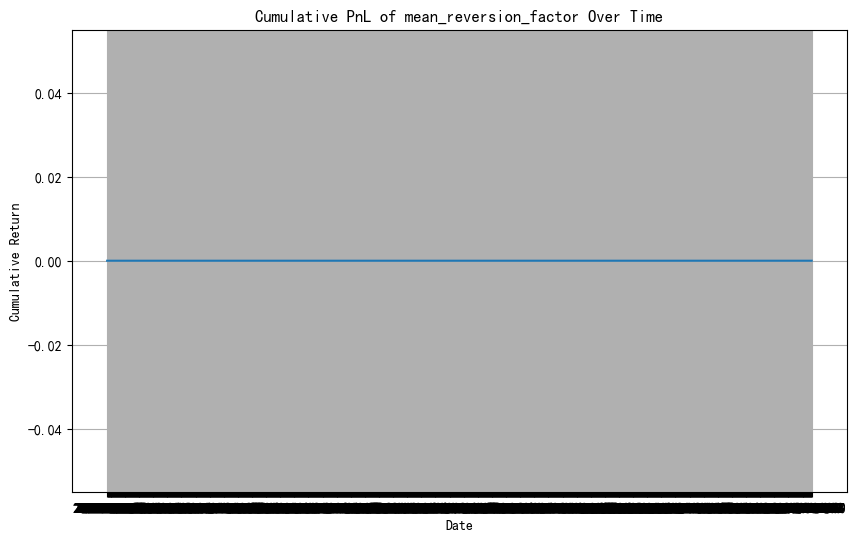

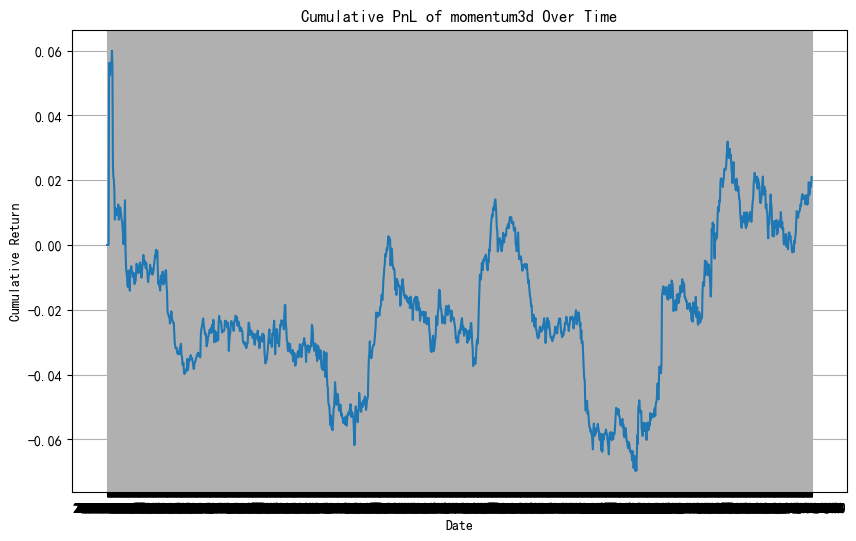

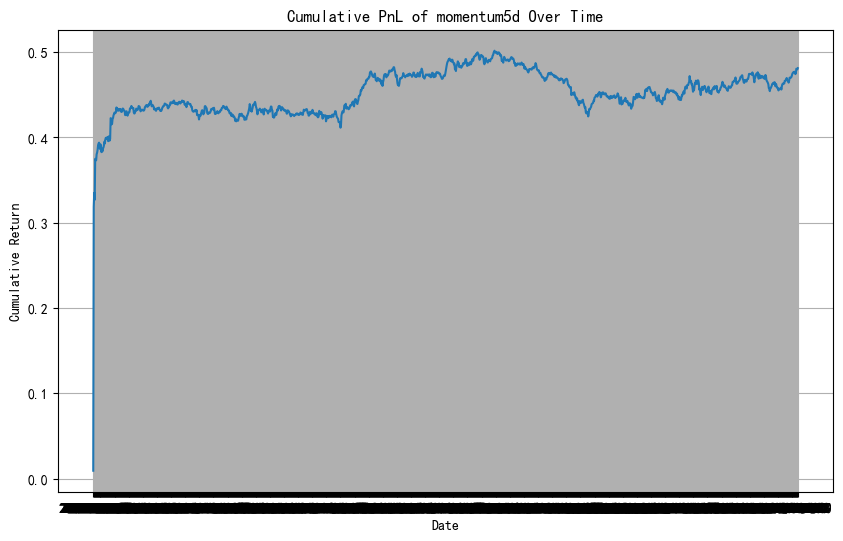

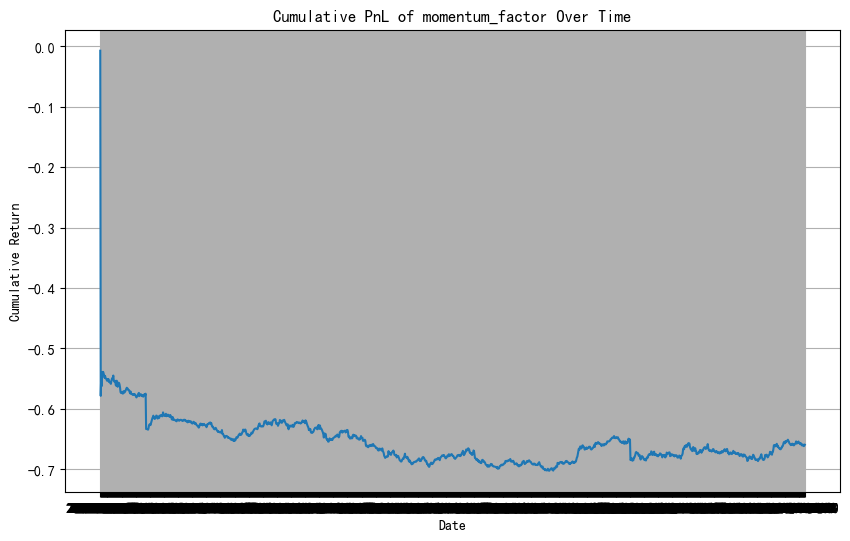

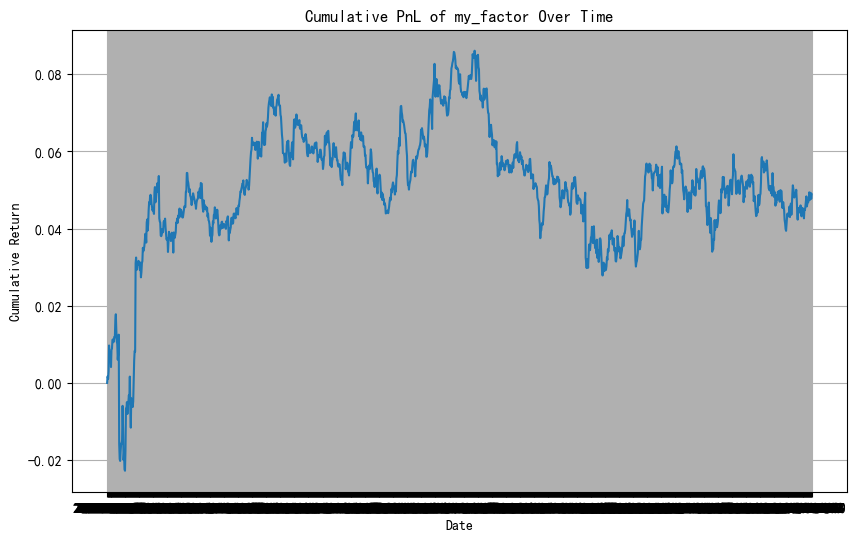

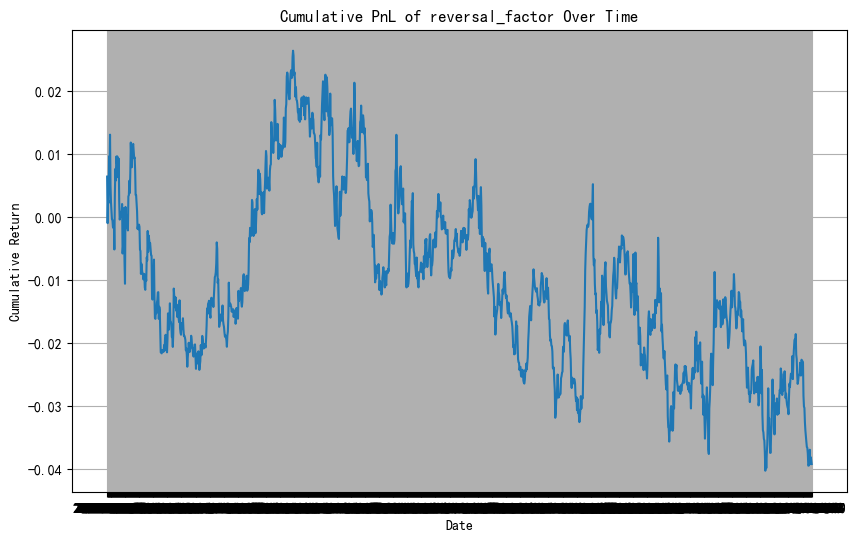

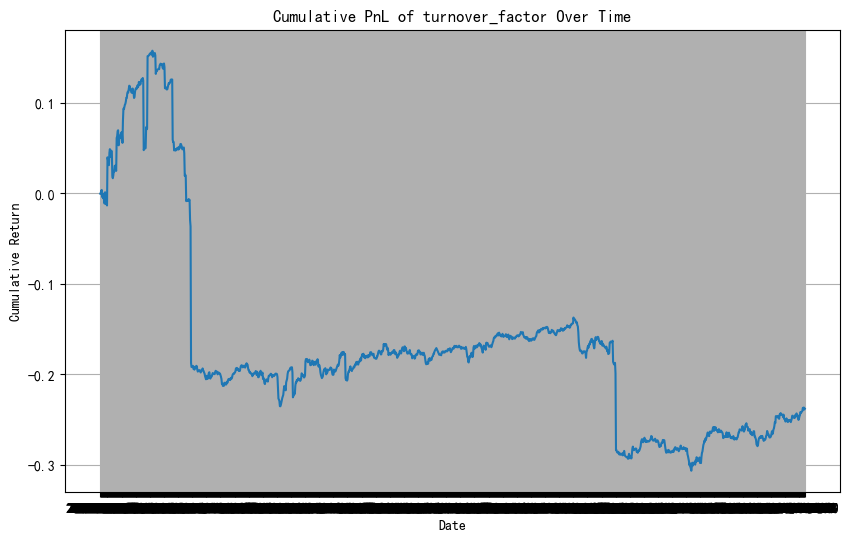

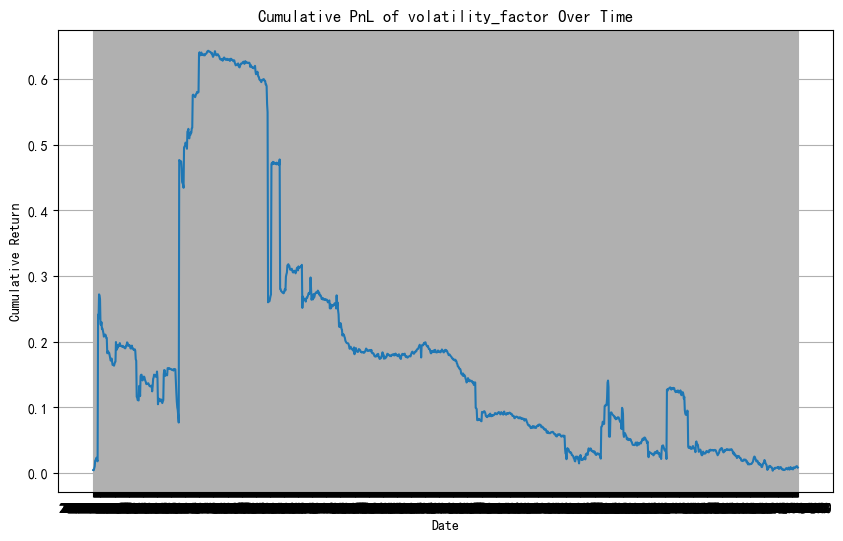

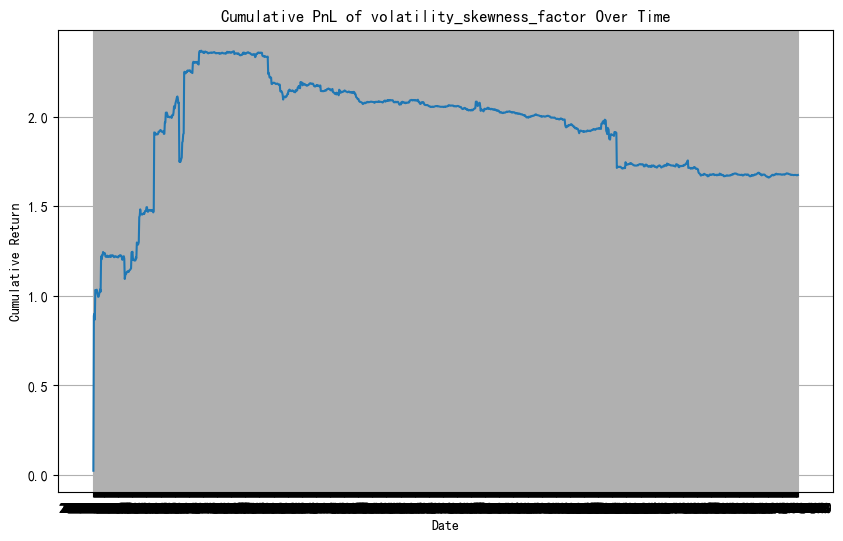

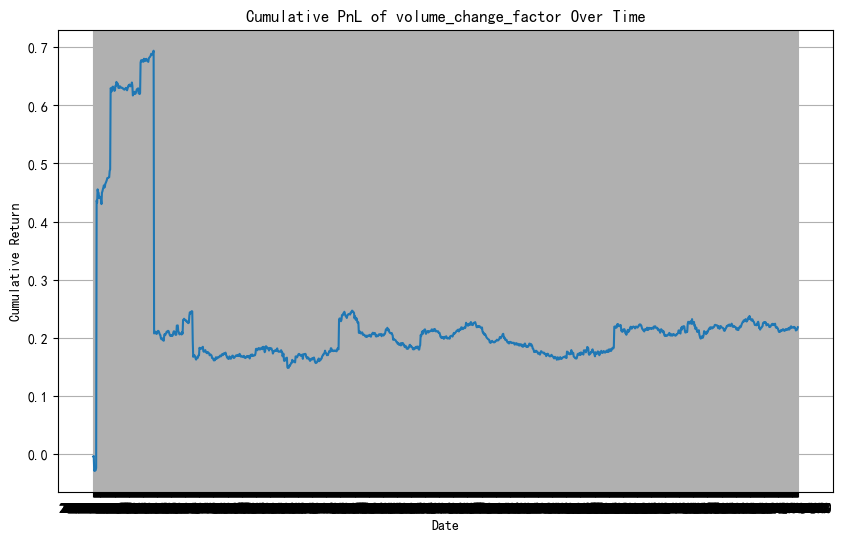

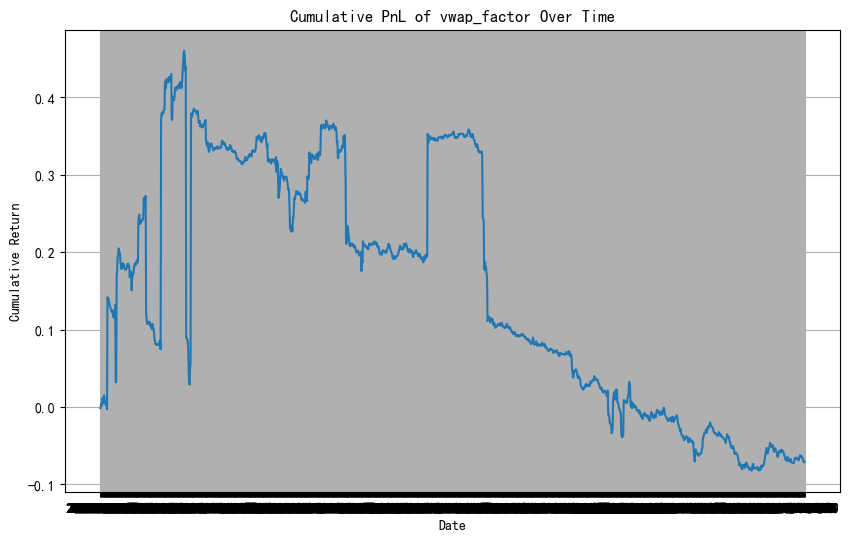

In [ ]:
#每个因子的pnl 和ret合并之后才能画
def draw_pnl(factor_ret,factorname):
    factor_df=(factor_ret[factor_ret['factor_name']==factorname]).pivot(index='Date',columns='Stockcode',values='factor_value')
    ret_df=(factor_ret[factor_ret['factor_name']==factorname]).pivot(index='Date',columns='Stockcode',values='ret')
    ptf_ret=(factor_df*ret_df).sum(axis=1)
    pnl=ptf_ret.cumsum()
    # 可视化累计PnL
    plt.figure(figsize=(10, 6))
    plt.plot(pnl.index,-pnl)
    plt.title(f'Cumulative PnL of {factorname} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()
    return pnl
factor_names=factor_ret['factor_name'].unique()
pnl_df=pd.DataFrame()
for name in factor_names:
    draw_pnl(factor_ret,name)

In [ ]:
factor_ret

,Date,Stockcode,factor_value,factor_name,rolling_mean_5,ewm_mean,rolling_mean,rolling_std,bias,chg,rank,ret
0,2016-01-04,000001,0.000000,mean_reversion_factor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
1,2016-01-04,000001,0.000000,momentum3d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
2,2016-01-04,000001,-0.014035,momentum5d,-0.005615,-0.003308,-0.005615,0.005137,-1.639112,-inf,8860.0,0.008571
3,2016-01-04,000001,-0.006471,momentum_factor,-0.001768,-0.001503,-0.001768,0.002822,-1.666436,-inf,8900.0,0.008571
4,2016-01-04,000001,0.000000,my_factor,0.002829,0.002204,0.002829,0.003875,-0.730136,-1.000000,6915.0,0.008571
...,...,...,...,...,...,...,...,...,...,...,...,...
3993391,2021-12-30,688981,0.006312,turnover_factor,0.003316,0.004129,0.003316,0.001980,1.512957,1.578261,137.0,0.001891
3993392,2021-12-30,688981,0.000000,volatility_factor,-0.001616,-0.001128,-0.001616,0.003613,0.447214,-1.000000,822.0,0.001891
3993393,2021-12-30,688981,0.005967,volatility_skewness_factor,0.004264,0.002759,0.004264,0.001387,1.228539,0.161903,268.0,0.001891
3993394,2021-12-30,688981,0.007305,volume_change_factor,0.002023,0.001263,0.002023,0.003742,1.411621,-18.048118,174.0,0.001891


In [ ]:
#pnl相关性矩阵
factor_names=factor_ret['factor_name'].unique()
pnl_cor_df=pd.DataFrame()
for name in factor_names:
    data=(factor_ret[factor_ret['factor_name']==name])
    data['weighted_ret']=data['factor_value']*data['ret']
    ret_series=pd.DataFrame(data.groupby('Date')['weighted_ret'].sum())
    ret_series.rename(columns={'weighted_ret':name},inplace=True)
    pnl_cor_df=pd.concat([pnl_cor_df,ret_series],axis=1)
pnl_cor_df

,mean_reversion_factor,momentum3d,momentum5d,momentum_factor,my_factor,reversal_factor,turnover_factor,volatility_factor,volatility_skewness_factor,volume_change_factor,vwap_factor
Date,,,,,,,,,,,
2016-01-04,0.0,0.000000,-0.009175,0.007262,0.000000,-0.006363,0.000361,-0.004584,-0.023736,0.003810,0.001257
2016-01-05,0.0,0.000000,-0.309285,0.571120,-0.001675,0.007393,-0.000938,0.000187,-0.864987,-0.000921,-0.001079
2016-01-06,0.0,0.000000,-0.016515,-0.032915,0.000656,-0.003652,-0.002270,-0.003041,-0.011633,0.025347,-0.004122
2016-01-07,0.0,0.000000,0.008171,0.016733,-0.001938,0.000444,-0.000948,-0.002727,0.032576,-0.002076,0.002006
2016-01-08,0.0,-0.051385,-0.048092,-0.023435,-0.006744,-0.007381,0.007792,-0.008908,-0.165375,0.001950,-0.008235
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,0.0,-0.000605,-0.001206,0.000051,0.001997,-0.001880,-0.003304,-0.001159,0.000109,0.003286,0.002485
2021-12-27,0.0,-0.002952,-0.005080,0.002168,-0.001349,0.002277,0.001637,-0.000725,0.001176,-0.001160,0.001697
2021-12-28,0.0,0.001163,0.000360,0.000398,-0.000523,-0.001086,-0.001975,-0.000305,0.000758,0.000139,0.001835


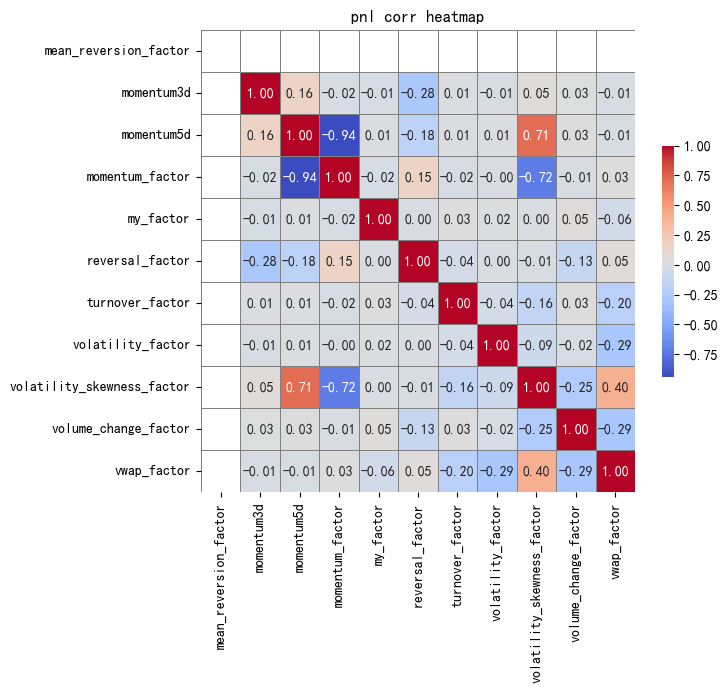

In [ ]:
#pnl相关性热力图
plt.figure(figsize=(7,6))
sns.heatmap(pnl_cor_df.corr(),annot=True,cmap='coolwarm',fmt=".2f",linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .5})
plt.title("pnl corr heatmap")
plt.show()

计算pnl的年化收益率、年化波动率、夏普比率和最大回撤

In [ ]:
#长表
factor_ret.dropna(inplace=True)
factor_ret

,Date,Stockcode,factor_value,factor_name,rolling_mean_5,ewm_mean,rolling_mean,rolling_std,bias,chg,rank,ret
0,2016-01-04,000001,0.000000,mean_reversion_factor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
1,2016-01-04,000001,0.000000,momentum3d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
2,2016-01-04,000001,-0.014035,momentum5d,-0.005615,-0.003308,-0.005615,0.005137,-1.639112,-inf,8860.0,0.008571
3,2016-01-04,000001,-0.006471,momentum_factor,-0.001768,-0.001503,-0.001768,0.002822,-1.666436,-inf,8900.0,0.008571
4,2016-01-04,000001,0.000000,my_factor,0.002829,0.002204,0.002829,0.003875,-0.730136,-1.000000,6915.0,0.008571
...,...,...,...,...,...,...,...,...,...,...,...,...
3993391,2021-12-30,688981,0.006312,turnover_factor,0.003316,0.004129,0.003316,0.001980,1.512957,1.578261,137.0,0.001891
3993392,2021-12-30,688981,0.000000,volatility_factor,-0.001616,-0.001128,-0.001616,0.003613,0.447214,-1.000000,822.0,0.001891
3993393,2021-12-30,688981,0.005967,volatility_skewness_factor,0.004264,0.002759,0.004264,0.001387,1.228539,0.161903,268.0,0.001891
3993394,2021-12-30,688981,0.007305,volume_change_factor,0.002023,0.001263,0.002023,0.003742,1.411621,-18.048118,174.0,0.001891


In [ ]:
warnings.filterwarnings("ignore")
def pnl_index(ret_series,factor):
    trade_day_count = 252
    AR = ret_series.sum() * trade_day_count / len(ret_series)
    AV = ret_series.std() * math.sqrt(trade_day_count)
    SR = ret_series.mean() / ret_series.std() * math.sqrt(trade_day_count)
    # 计算累积净值
    cumulative_returns =1 + ret_series.cumsum()
    # 计算累积最大值
    cumulative_max = cumulative_returns.cummax()
    # 计算回撤
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    # 找出最大回撤
    max_drawdown = (drawdown.min())
    
    result_data = [
        {"index_name": f"Annualized Return {factor}", "index_value": AR},
        {"index_name": f"Annualized Volatility {factor}", "index_value": AV},
        {"index_name": f"Sharpe Ratio {factor}", "index_value": SR},
        {"index_name": f"Maximum Drawdown {factor}", "index_value": max_drawdown}
    ]
    
    result = pd.DataFrame(result_data)
    
    return result

factor_names=factor_ret['factor_name'].unique()
pnl_df=pd.DataFrame()
for factor in factor_names:
    data=(factor_ret[factor_ret['factor_name']==factor])
    data['weighted_ret']=data['factor_value']*data['ret']
    ret_series=data.groupby('Date')['weighted_ret'].sum()
    pnl_result=pd.DataFrame(pnl_index(ret_series,factor))
    pnl_df=pd.concat([pnl_df,pnl_result],ignore_index=True)
pnl_df

,index_name,index_value
0,Annualized Return mean_reversion_factor,0.000000
1,Annualized Volatility mean_reversion_factor,0.000000
2,Sharpe Ratio mean_reversion_factor,NaN
3,Maximum Drawdown mean_reversion_factor,0.000000
4,Annualized Return momentum3d,-0.003617
5,Annualized Volatility momentum3d,0.044337
6,Sharpe Ratio momentum3d,-0.081581
7,Maximum Drawdown momentum3d,-0.094952
8,Annualized Return momentum5d,-0.083051
9,Annualized Volatility momentum5d,0.135006


分层回测图

等值加权 bias 0.72 分层明显 chg 0.11 0.82 分层不明显
因子值加权 chg 0.43 0.10 1.15 第三组分层最明显 多空组最好 组1其次
因子值加权 chg dropna过后 0.22 0.64 0.26分层都不明显
因子值加权 rank 0.83 0.74 1.14 分层明显 因子分布看着厚尾 ic负的很奇怪不知道哪里错了 前面的一系列数据处理，有时候少几个步骤反倒ic更高分层更明显

In [ ]:
#记得调整by=
#可调整组内加权方式
def calculate_group_returns(factor_ret):
    """
    根据因子信号值的排序分组，计算每一组的收益
    :param data: 包含Ticker、日期、时间、高开低收价格、label的DataFrame
    :return: 每个分组的日度平均收益率序列
    """
    tradingdays = factor_ret['Date'].unique()
    tradingdays.sort()
    daily_profit = pd.DataFrame()
    
    for day in tradingdays:
        dt_data = factor_ret[factor_ret['Date'] == day]
        stock_list = dt_data.sort_values(by='factor_value')['Stockcode'].tolist()
        n_stocks = len(stock_list)
        group1 = stock_list[int(0 * n_stocks): int(0.2 * n_stocks)]
        group2 = stock_list[int(0.2 * n_stocks): int(0.4 * n_stocks)]
        group3 = stock_list[int(0.4 * n_stocks): int(0.6 * n_stocks)]
        group4 = stock_list[int(0.6 * n_stocks): int(0.8 * n_stocks)]
        group5 = stock_list[int(0.8 * n_stocks): int(1 * n_stocks)]
        dt_data = dt_data.set_index('Stockcode')
        rate_daily = pd.DataFrame(columns =['组1','组2','组3','组4', '组5', '多空'])
        #等值加权
        rate_daily.loc[0, '组1'] = dt_data.loc[group1]['ret'].mean()
        rate_daily.loc[0, '组2'] = dt_data.loc[group2]['ret'].mean()
        rate_daily.loc[0, '组3'] = dt_data.loc[group3]['ret'].mean()
        rate_daily.loc[0, '组4'] = dt_data.loc[group4]['ret'].mean()
        rate_daily.loc[0, '组5'] = dt_data.loc[group5]['ret'].mean()
        """
        #因子值加权
        rate_daily.loc[0, '组1'] = (dt_data.loc[group1]['ret']*dt_data.loc[group1]['factor_value']).sum()
        rate_daily.loc[0, '组2'] = (dt_data.loc[group2]['ret']*dt_data.loc[group2]['factor_value']).sum()
        rate_daily.loc[0, '组3'] = (dt_data.loc[group3]['ret']*dt_data.loc[group3]['factor_value']).sum()
        rate_daily.loc[0, '组4'] = (dt_data.loc[group4]['ret']*dt_data.loc[group4]['factor_value']).sum()
        rate_daily.loc[0, '组5'] = (dt_data.loc[group5]['ret']*dt_data.loc[group5]['factor_value']).sum()"""
        
        rate_daily.loc[0, "多空"] = rate_daily.loc[0,'组1']  + (-1 * rate_daily.loc[0,'组5'])
        daily_profit = pd.concat([daily_profit, rate_daily])
    daily_profit['dt'] = tradingdays
    return daily_profit


In [ ]:
def calculate_performance_metrics(daily_profit):
    """
    计算回测指标：IC、年化收益率、最大回撤
    :param daily_profit: 每个分组的日度平均收益率序列
    :return: IC值、年化收益率、夏普比率
    多空收益组要根据因子值的正负改变符号
    """
    #处理na
    daily_profit=daily_profit.fillna(0)
    
    daily_profit['cumsum_annual_ret_组1'] = daily_profit['组1'].cumsum(skipna=True) # 把日度收益累加
    daily_profit['cumsum_annual_ret_组2'] = daily_profit['组2'].cumsum(skipna=True) # 把日度收益累加
    daily_profit['cumsum_annual_ret_组3'] = daily_profit['组3'].cumsum(skipna=True) # 把日度收益累加
    daily_profit['cumsum_annual_ret_组4'] = daily_profit['组4'].cumsum(skipna=True) # 把日度收益累加
    daily_profit['cumsum_annual_ret_组5'] = daily_profit['组5'].cumsum(skipna=True) # 把日度收益累加
    daily_profit['cumsum_annual_ret_多空'] = -daily_profit['cumsum_annual_ret_组5'] +daily_profit['cumsum_annual_ret_组1']
    
    # 计算多空组的年化收益率、波动率、夏普比率
    ann_return = list(daily_profit['cumsum_annual_ret_多空'])[-1] / (daily_profit.shape[0] / 250)
    ann_vol = np.std(daily_profit['多空'], axis=0, ddof=1) * np. sqrt(250.0)
    ann_sharpe = ann_return / ann_vol

    return daily_profit,ann_return, ann_vol, ann_sharpe

def plot_factor_quantiles(daily_profit,factor):
    
    daily_profit['dt'] = pd.to_datetime(daily_profit['dt'], format='%Y-%m-%d')
    plt.figure(figsize=(14, 7))
    for group in ['cumsum_annual_ret_组1', 'cumsum_annual_ret_组2', 'cumsum_annual_ret_组3', 'cumsum_annual_ret_组4', 'cumsum_annual_ret_组5', 'cumsum_annual_ret_多空']:
        plt.plot(daily_profit['dt'], daily_profit[group], label=group)
    #plt.title(f'{name} 多空累计收益曲线')
    plt.title('分层回测图')
    plt.xlabel('日期')
    plt.ylabel(f'{factor}收益率')
    plt.legend()


         组1        组2        组3        组4        组5        多空          dt  \
0  0.014227 -0.016197  0.007872 -0.024326 -0.031178  0.045404  2016-01-04   
0  0.055519  0.040829  0.038774 -0.007537 -1.401208  1.456727  2016-01-05   
0 -0.144891 -0.119773 -0.105247 -0.157241 -0.132457 -0.012434  2016-01-06   
0  0.060479  0.035142  0.053677  0.010278  0.107823 -0.047344  2016-01-07   
0 -0.137942 -0.075726 -0.087339 -0.269466 -0.221592  0.083650  2016-01-08   

   cumsum_annual_ret_组1  cumsum_annual_ret_组2  cumsum_annual_ret_组3  \
0              0.014227             -0.016197              0.007872   
0              0.069746              0.024632              0.046646   
0             -0.075145             -0.095141             -0.058602   
0             -0.014666             -0.059999             -0.004925   
0             -0.152608             -0.135725             -0.092263   

   cumsum_annual_ret_组4  cumsum_annual_ret_组5  cumsum_annual_ret_多空  
0             -0.024326             -0.0

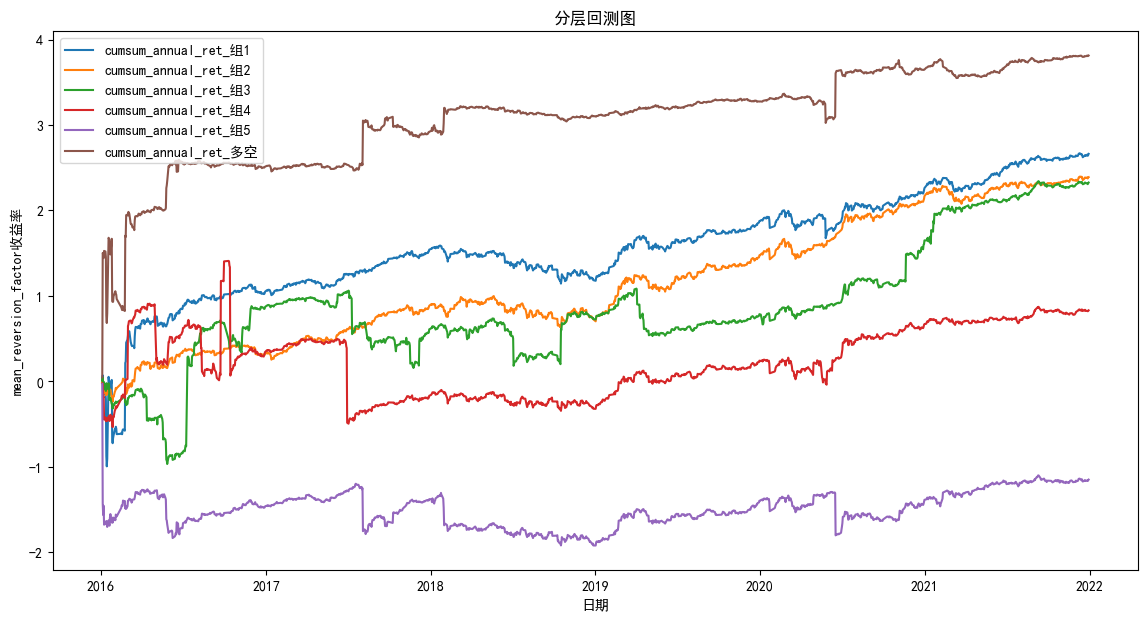

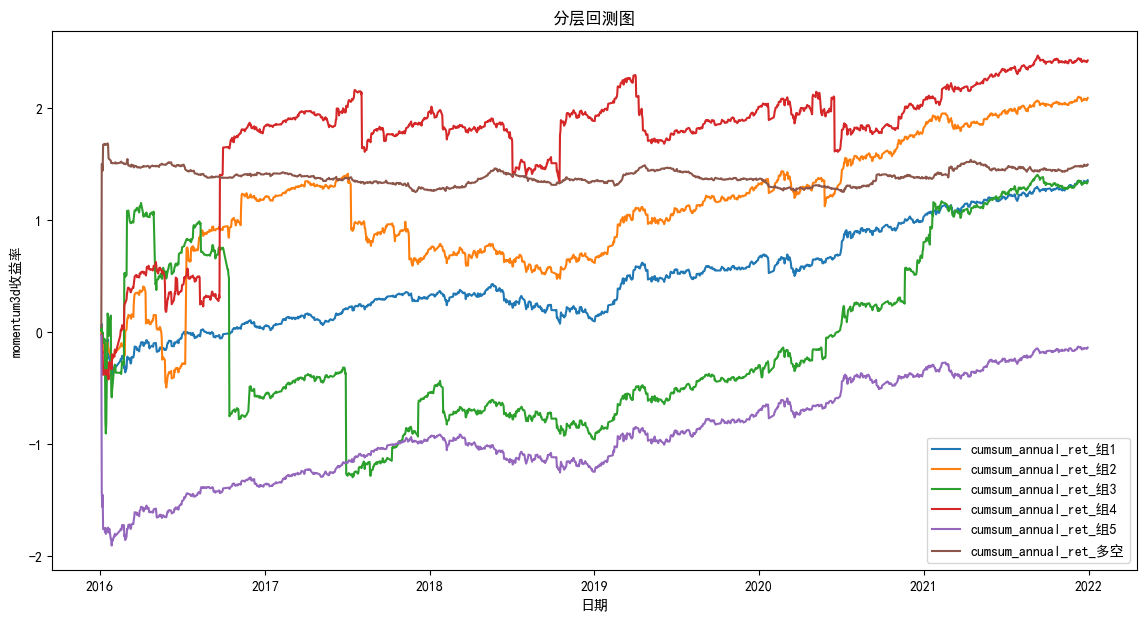

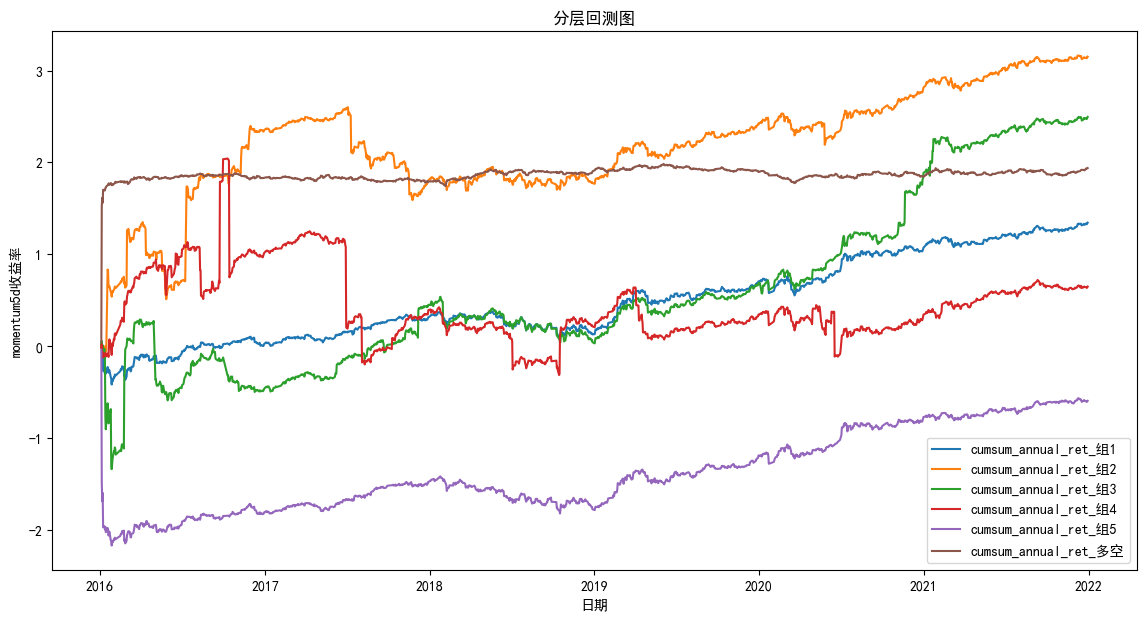

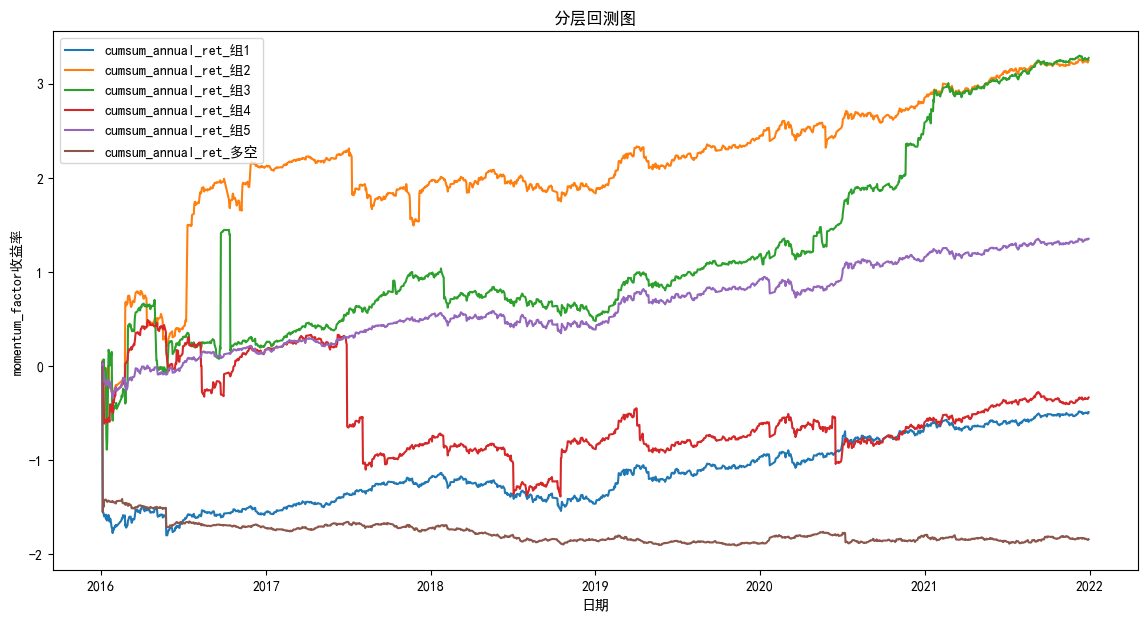

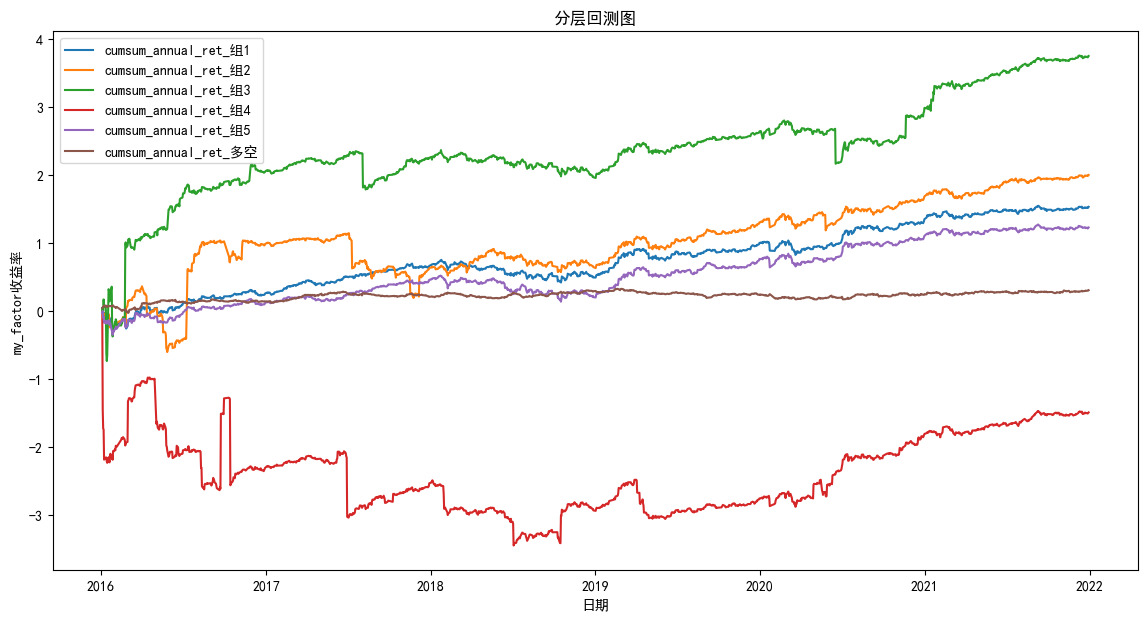

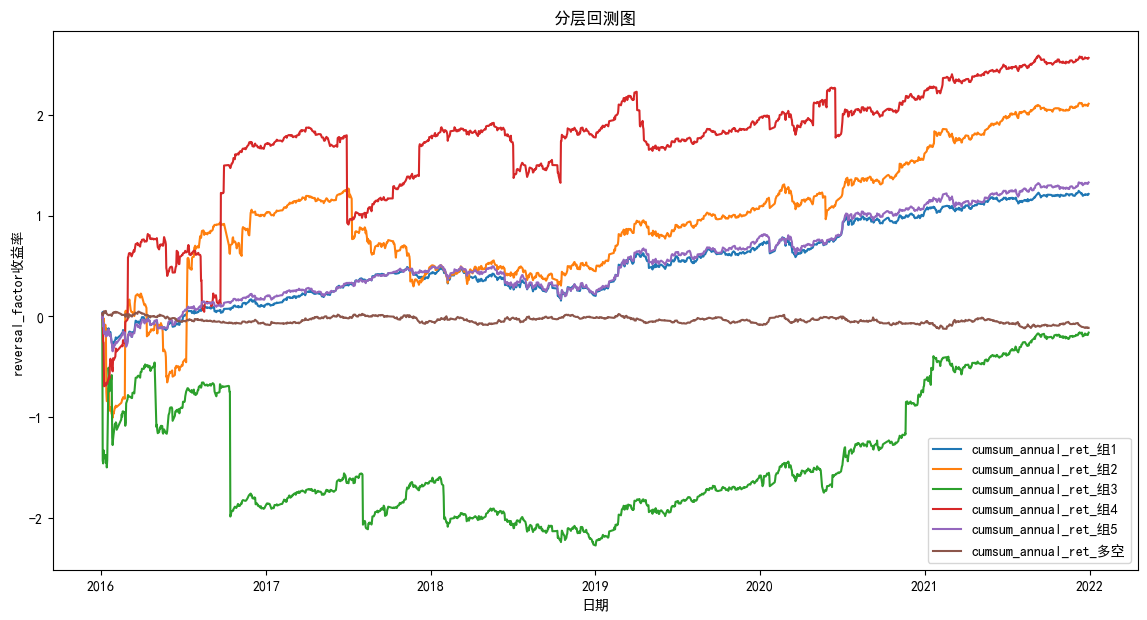

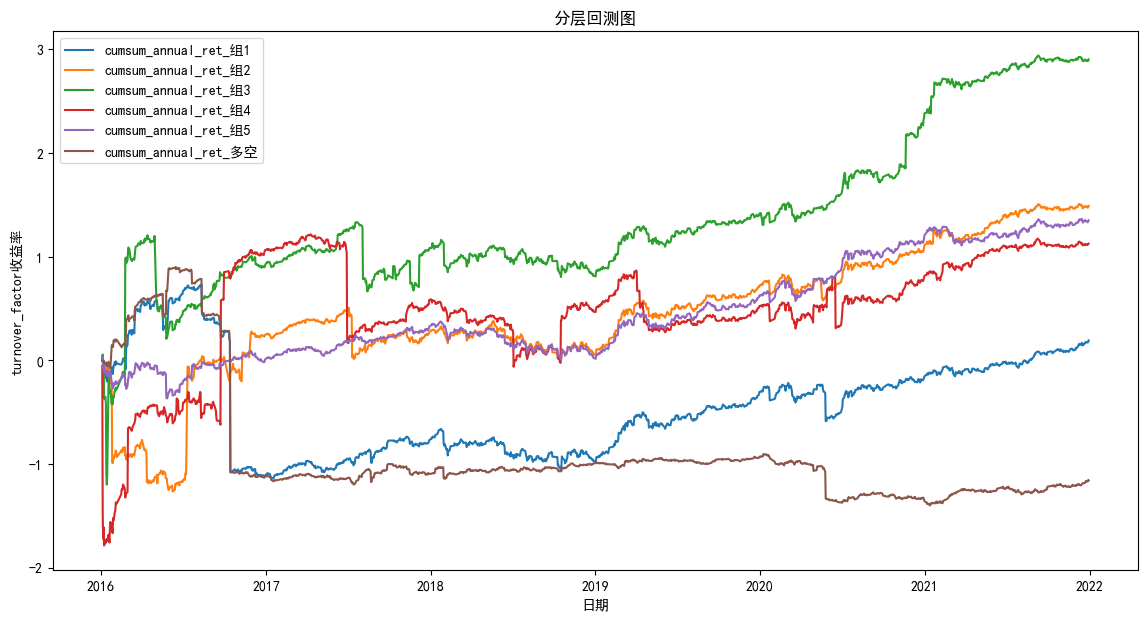

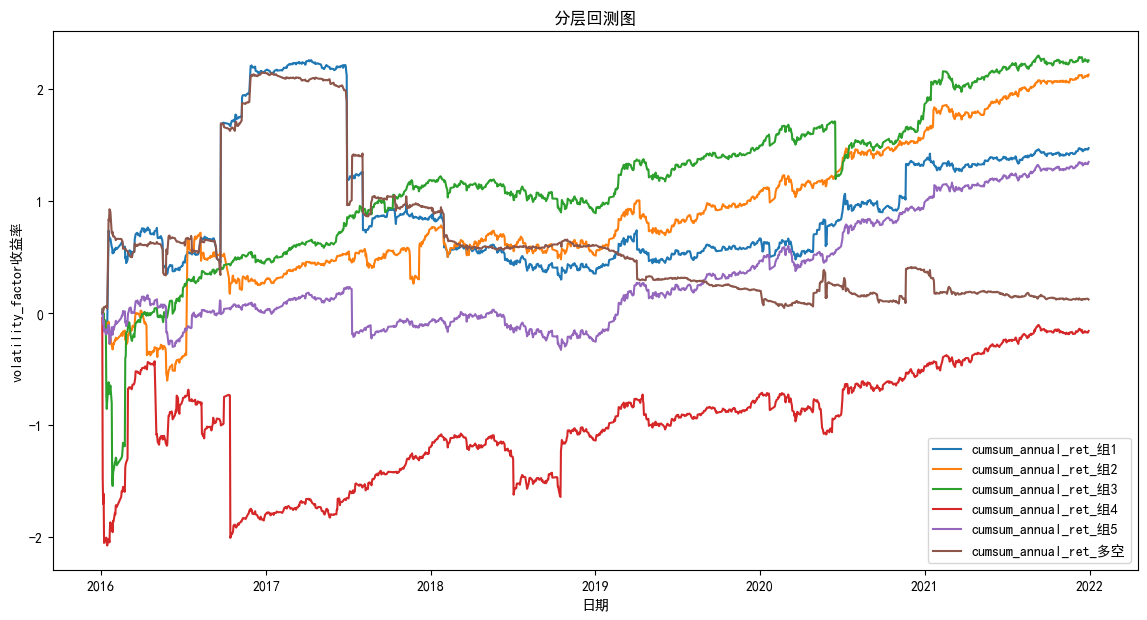

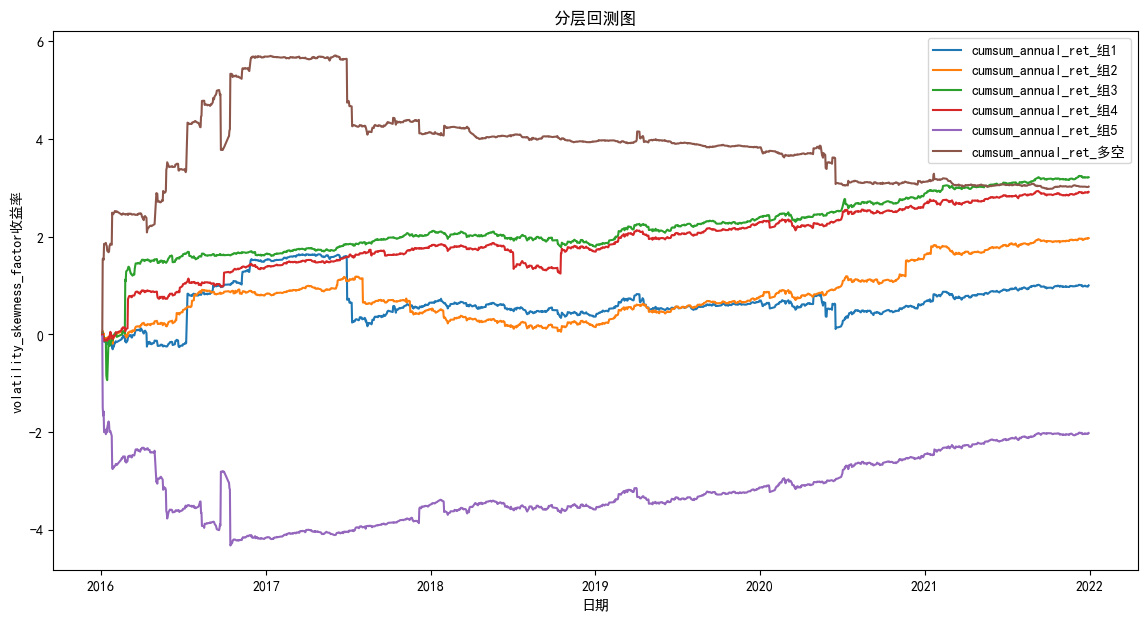

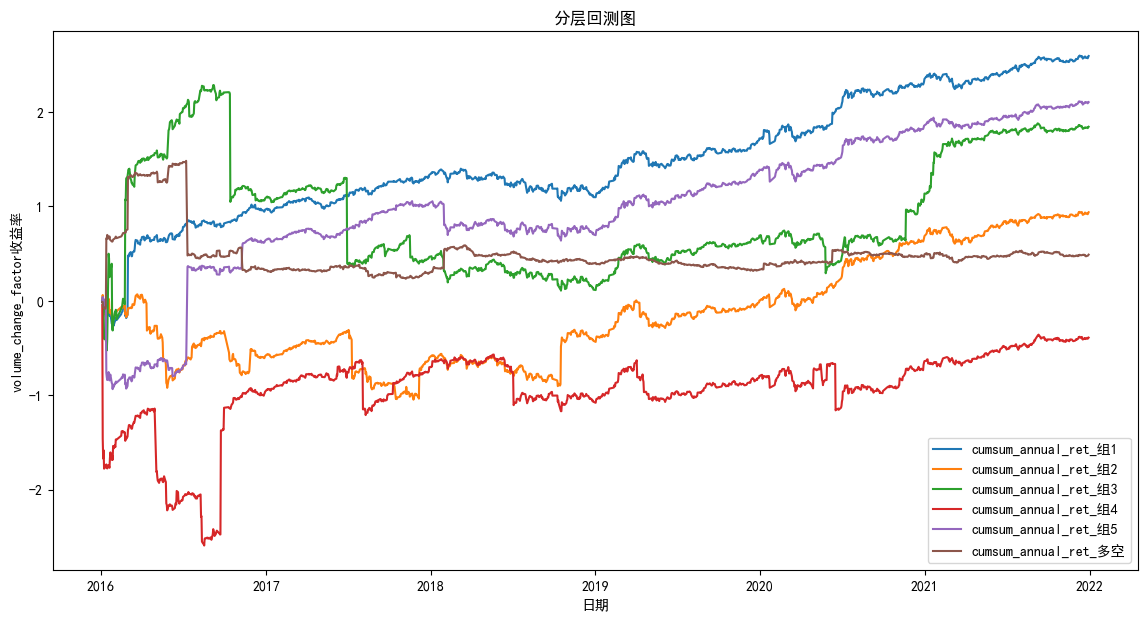

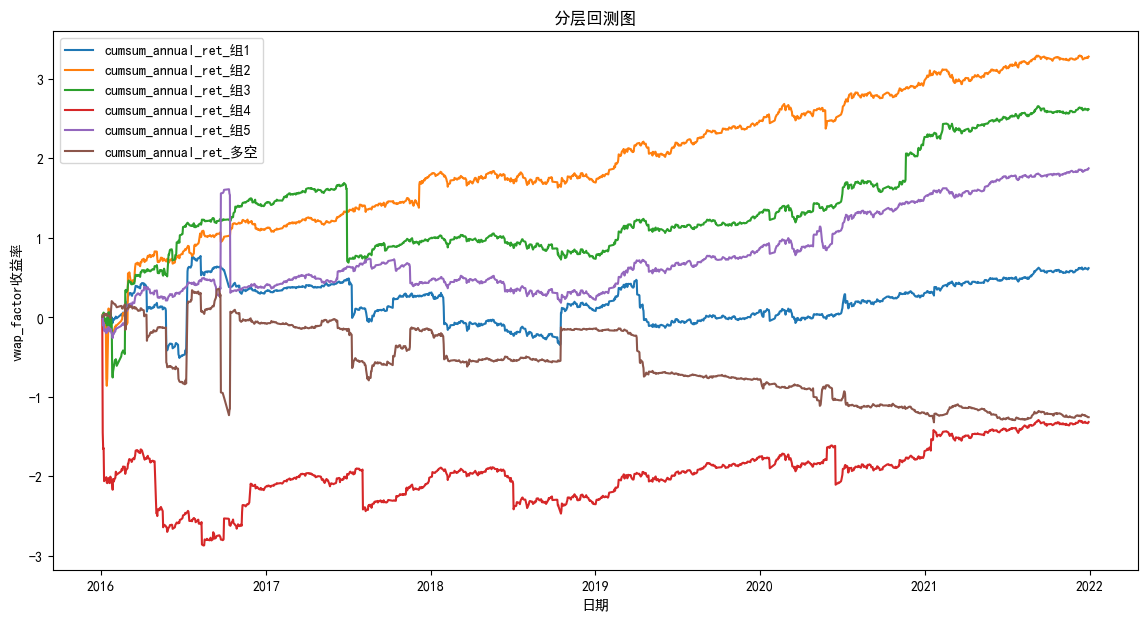

In [ ]:
factor_names=factor_ret['factor_name'].unique()
for factor in factor_names:
    daily_profit=calculate_group_returns(factor_ret[factor_ret['factor_name']==factor])
    daily_profit,ann_return, ann_vol, ann_sharpe = calculate_performance_metrics(daily_profit)
    print(daily_profit.iloc[:5,:])
    print('多空_ann_return:', round(ann_return, 4), '多空_ann_vol:', round(ann_vol, 4), '多空_ann_sharpe:', round(ann_sharpe, 4))
    plot_factor_quantiles(daily_profit,factor)

算时序截面ic

In [ ]:
#计算某一列因子的ic前先改列名为factor_value 选中chg这一列作为因子值计算时序截面上的ic
factor_ret=factor_ret.drop(columns=['factor_value'])
factor_ret.rename(columns={'chg':'factor_value'},inplace=True)
factor_ret

,Date,Stockcode,factor_name,rolling_mean_5,ewm_mean,rolling_mean,rolling_std,bias,factor_value,rank,ret
0,2016-01-04,000001,mean_reversion_factor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
1,2016-01-04,000001,momentum3d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4569.0,0.008571
2,2016-01-04,000001,momentum5d,-0.005615,-0.003308,-0.005615,0.005137,-1.639112,-inf,8860.0,0.008571
3,2016-01-04,000001,momentum_factor,-0.001768,-0.001503,-0.001768,0.002822,-1.666436,-inf,8900.0,0.008571
4,2016-01-04,000001,my_factor,0.002829,0.002204,0.002829,0.003875,-0.730136,-1.000000,6915.0,0.008571
...,...,...,...,...,...,...,...,...,...,...,...
3993391,2021-12-30,688981,turnover_factor,0.003316,0.004129,0.003316,0.001980,1.512957,1.578261,137.0,0.001891
3993392,2021-12-30,688981,volatility_factor,-0.001616,-0.001128,-0.001616,0.003613,0.447214,-1.000000,822.0,0.001891
3993393,2021-12-30,688981,volatility_skewness_factor,0.004264,0.002759,0.004264,0.001387,1.228539,0.161903,268.0,0.001891
3993394,2021-12-30,688981,volume_change_factor,0.002023,0.001263,0.002023,0.003742,1.411621,-18.048118,174.0,0.001891


In [ ]:
def calculate_IC_date(factor_ret):
    grouped = factor_ret.groupby(['Date', 'factor_name'])

    ic_values = []

    for (date, factorname), group in grouped:
        group = group.dropna(subset=['factor_value', 'ret']).replace([np.inf, -np.inf], np.nan).dropna()
        if len(group) > 1:
                ic, _ = pearsonr(group['factor_value'], group['ret'])
                rankic, _ = spearmanr(group['factor_value'], group['ret'])
                ic_values.append({'factor_name': factorname, 'ic': ic, 'Date': date,'RankIC': rankic,'stockcode':group['Stockcode']})
            

    ic_values_df = pd.DataFrame(ic_values)
    ic_values_df
    ic_mean = (
            ic_values_df.groupby('factor_name')[['ic', 'RankIC']].mean().reset_index()
            .rename(columns={'ic': 'ic_mean', 'RankIC': 'RankIC_mean'})
        )

    return ic_mean,ic_values

In [ ]:
def calculate_IC_code(factor_ret):
    grouped = factor_ret.groupby(['factor_name','Stockcode'])

    ic_values = []

    for (factorname,stockcode), group in grouped:
        group = group.dropna(subset=['factor_value', 'ret']).replace([np.inf, -np.inf], np.nan).dropna()
        if len(group) > 1:
                ic, _ = pearsonr(group['factor_value'], group['ret'])
                rankic, _ = spearmanr(group['factor_value'], group['ret'])
                ic_values.append({'factor_name': factorname, 'ic': ic,'RankIC': rankic,'stockcode':stockcode,'date':group['Date']})
            

    ic_values_df = pd.DataFrame(ic_values)
    ic_values_df
    ic_mean = (
            ic_values_df.groupby('factor_name')[['ic', 'RankIC']].mean().reset_index()
            .rename(columns={'ic': 'ic_mean', 'RankIC': 'RankIC_mean'})
        )

    return ic_mean,ic_values

In [ ]:
#时序ic
ic_ric_mean,ic_values=calculate_IC_date(factor_ret)
ic_ric_mean

,factor_name,ic_mean,RankIC_mean
0,mean_reversion_factor,NaN,NaN
1,momentum3d,-0.000015,0.000324
2,momentum5d,0.001084,0.001688
3,momentum_factor,-0.002356,-0.002213
4,my_factor,-0.000606,-0.002763
5,reversal_factor,0.000556,0.003690
6,turnover_factor,-0.000016,0.002785
7,volatility_factor,-0.001329,0.000080
8,volatility_skewness_factor,-0.001482,0.004005
9,volume_change_factor,0.000460,-0.003663


In [ ]:
#时序ic
ic_value=pd.DataFrame(ic_values)
ic_value

,factor_name,ic,Date,RankIC,stockcode
0,mean_reversion_factor,NaN,2016-01-04,NaN,0 000001 30734 000063 46013 ...
1,momentum3d,NaN,2016-01-04,NaN,1 000001 30735 000063 46014 ...
2,momentum5d,-0.033697,2016-01-04,-0.121792,46015 000100 60249 000157 76309 ...
3,momentum_factor,0.012496,2016-01-04,-0.040335,30737 000063 46016 000100 60250 ...
4,my_factor,-0.123037,2016-01-04,-0.079061,4 000001 30738 000063 46017 ...
...,...,...,...,...,...
16055,turnover_factor,0.032711,2021-12-30,0.119024,16055 000001 30729 000002 46008 ...
16056,volatility_factor,0.007269,2021-12-30,0.058136,16056 000001 30730 000002 46009 ...
16057,volatility_skewness_factor,0.072409,2021-12-30,0.017923,16057 000001 30731 000002 46010 ...
16058,volume_change_factor,-0.054596,2021-12-30,-0.126761,16058 000001 30732 000002 46011 ...


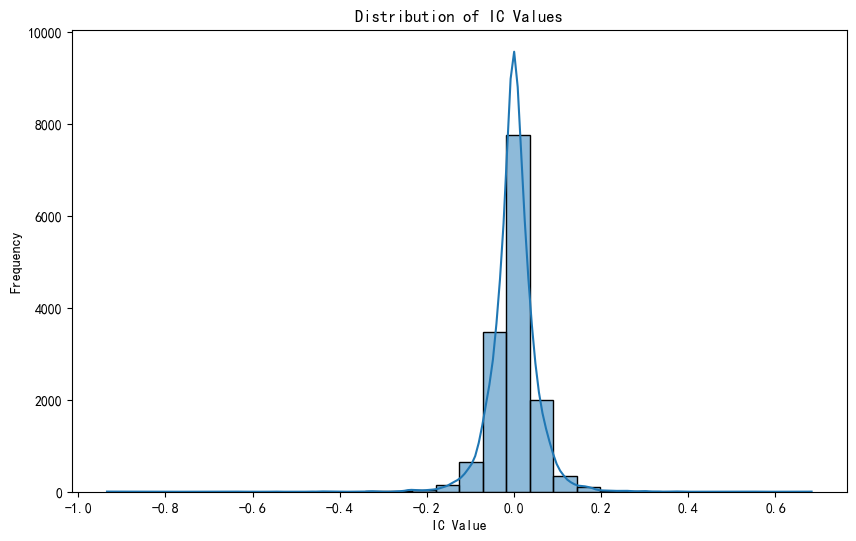

In [ ]:
# 提取 ic 列的数据
ic_data = ic_value['ic']

# 制 ic 的分布图
plt.figure(figsize=(10, 6))
sns.histplot(ic_data, kde=True, bins=30)
plt.title('Distribution of IC Values')
plt.xlabel('IC Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#截面ic
ic_ric_mean,ic_values=calculate_IC_code(factor_ret)
ic_ric_mean

,factor_name,ic_mean,RankIC_mean
0,mean_reversion_factor,NaN,NaN
1,momentum3d,0.002938,0.001261
2,momentum5d,0.001301,0.004296
3,momentum_factor,-0.001398,-0.002135
4,my_factor,0.000886,-0.004340
5,reversal_factor,0.004250,0.003577
6,turnover_factor,-0.001389,0.001901
7,volatility_factor,0.000642,-0.001149
8,volatility_skewness_factor,0.000062,-0.000821
9,volume_change_factor,-0.001920,-0.004566


In [ ]:
#截面ic
ic_value=pd.DataFrame(ic_values)
ic_value

,factor_name,ic,RankIC,stockcode,date
0,mean_reversion_factor,NaN,NaN,000001,0 2016-01-04 11 2016-01-05 22 ...
1,mean_reversion_factor,NaN,NaN,000002,16060 2016-07-04 16071 2016-07-05 16082 ...
2,mean_reversion_factor,NaN,NaN,000063,30734 2016-01-04 30745 2016-01-05 30756 ...
3,mean_reversion_factor,NaN,NaN,000100,46013 2016-01-04 46024 2016-01-05 46035 ...
4,mean_reversion_factor,NaN,NaN,000157,60247 2016-01-04 60258 2016-01-05 60269 ...
...,...,...,...,...,...
3163,vwap_factor,0.068837,0.029208,688256,3975223 2020-07-20 3975234 2020-07-21 39...
3164,vwap_factor,0.081353,0.219636,688303,3979128 2021-07-22 3979139 2021-07-23 39...
3165,vwap_factor,-0.037964,-0.015786,688396,3980327 2020-02-27 3980338 2020-02-28 39...
3166,vwap_factor,-0.030114,0.018319,688599,3985288 2020-06-10 3985299 2020-06-11 39...


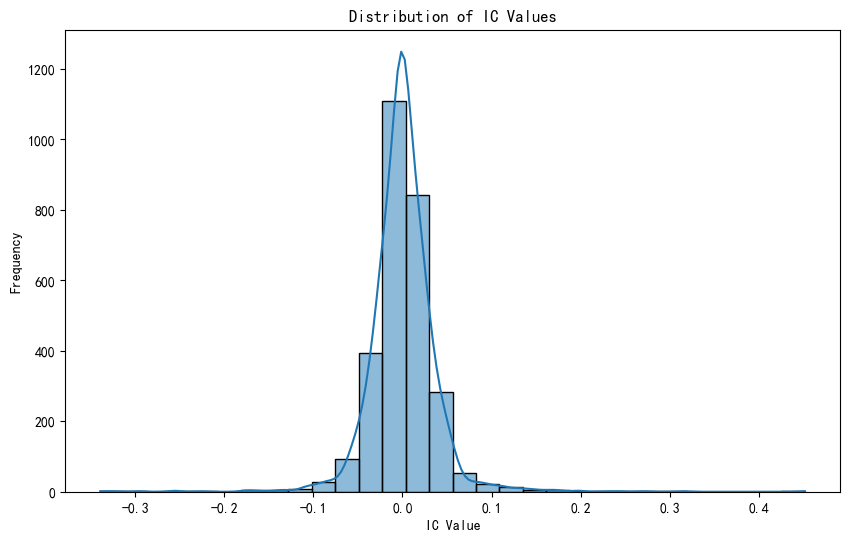

In [ ]:
# 提取 ic 列的数据
ic_data = ic_value['ic']

# 制 ic 的分布图
plt.figure(figsize=(10, 6))
sns.histplot(ic_data, kde=True, bins=30)
plt.title('Distribution of IC Values')
plt.xlabel('IC Value')
plt.ylabel('Frequency')
plt.show()